<a href="https://colab.research.google.com/github/mglavan07/HYDAC_Capacity_Forecasting_Models/blob/main/CenterInheritance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
if __name__ == "__main__":
  from google.colab import drive
  drive.mount('/content/drive')

  import sys
  sys.path.append('/content/drive/MyDrive/Colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
if __name__ == "__main__":
  import dataseparation as ds
  import clustersiblings as cs

In [48]:
# define a function to merge clusters with data and seprarate by cluster
def merge_separate_clusters(data, cluster_data):
  try:

    # import libraries
    import pandas as pd

    # Add cluster-related columns to the main data manually, avoiding duplicates
    cluster_map = cluster_data.set_index('Material')

    # Create new columns in the `data` dataframe for 'Cluster', 'Total Quantity', 'Total Revenue'
    data['Cluster'] = data['Material'].map(cluster_map['Cluster'])
    data['Total Quantity'] = data['Material'].map(cluster_map['Total Quantity'])
    data['Total Revenue'] = data['Material'].map(cluster_map['Total Revenue'])

    # Get unique cluster labels
    unique_clusters = data['Cluster'].unique()

    # Create a list of dataframes, one per cluster
    cluster_dfs = []
    for cluster in unique_clusters:
        cluster_df = data[data['Cluster'] == cluster].copy()
        cluster_dfs.append(cluster_df)

    return cluster_dfs

  # flag errors
  except KeyError:
      print(f"Error: not all columns located")
      return pd.DataFrame()
  except ModuleNotFoundError:
      print("Error: pandas is not installed.")
      return pd.DataFrame()
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return pd.DataFrame()


In [49]:
# define a function to separate a dataframe into time histories for revenue and quantity
def qr_vs_time(data):

  try:

    # import libraries
    import pandas as pd

    # slice the dataframe
    data['Date'] = pd.to_datetime(data['Date'])
    data['NET SALES'] = abs(data['NET SALES'])
    data['Invoiced Quantity'] = abs(data['Invoiced Quantity'])
    data = data[['Date', 'Material', 'Invoiced Quantity', 'NET SALES']]

    # Sort by Date to ensure cumulative sums are correct
    data = data.sort_values(['Material', 'Date'])

    # Group by Material
    data = data.groupby('Material')
    result = pd.DataFrame({
        'Material': data.groups.keys(),
        'Date List': [group['Date'].tolist() for _, group in data],
        'Cumulative Quantity List': [group['Invoiced Quantity'].cumsum().tolist() for _, group in data],
        'Cumulative Revenue List': [group['NET SALES'].cumsum().tolist() for _, group in data]
    })
    return result

  # flag errors
  except KeyError:
      print(f"Error: not all columns located")
      return pd.DataFrame()
  except ModuleNotFoundError:
      print("Error: pandas is not installed.")
      return pd.DataFrame()
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return pd.DataFrame()

In [50]:
def forecast_material_NN(data, years_future, epochs=150, lr=0.01, lambda_penalty=8, visualize=False):
  try:

    # import modules
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # define the model class inheriting from PyTorch library
    class ForecastNN(nn.Module):
        def __init__(self, input_dim=5, hidden_dim=32, output_dim=2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, x):
            return self.net(x)

    # bin to store results for analysis
    results = []

    # mark today and 2011 to standardize the interval for possible sales
    today = pd.Timestamp.today().normalize()
    start_date = pd.Timestamp('2011-01-01')

    # run the model for each material passed in the cluster
    for idx, row in data.iterrows():

        # take data from clustering
        material = row['Material']
        dates = pd.Series(row['Date List'])
        cum_qty = np.array(row['Cumulative Quantity List'])
        cum_rev = np.array(row['Cumulative Revenue List'])

        # insert January 1, 2011 as baseline start date if not present
        if start_date not in dates.values:
            dates = pd.concat([pd.Series([start_date]), dates], ignore_index=True)
            cum_qty = np.insert(cum_qty, 0, 0)  # baseline quantity = 0
            cum_rev = np.insert(cum_rev, 0, 0)  # baseline revenue = 0

        # insert today if today > last date
        if today > dates.iloc[-1]:
            dates = pd.concat([dates, pd.Series([today])], ignore_index=True)
            cum_qty = np.append(cum_qty, cum_qty[-1])  # last known qty repeated for today
            cum_rev = np.append(cum_rev, cum_rev[-1])  # last known rev repeated for today

        # scale the data back in terms of years (independent var.)
        base_date = dates.min()
        years = (dates - base_date).dt.days / 365.25

        # make sure the dataset was originally long enough to perform NN on
        if len(dates) < 5: # need at least 3 sales
            results.append({
                "Material": material,
                "Current Cumulative Revenue": cum_rev[-1],
                "Future Cumulative Revenue": cum_rev[-1],
                "Current Cumulative Quantity": cum_qty[-1],
                "Future Cumulative Quantity": cum_qty[-1],
                f"Pred. {years_future}-Year Quantity Gain": 0,
                f"Pred. {years_future}-Year Revenue Gain": 0,
                "Last Sale": list(years)[-2]
            })
            continue

        # define a function to generate model features
        def create_features(date_series):
            years_f = (date_series - base_date).dt.days / 365.25
            months = date_series.dt.month
            sin_year = np.sin(2 * np.pi * years_f) # sinusiodal trends to be learned
            cos_year = np.cos(2 * np.pi * years_f)
            sin_month = np.sin(2 * np.pi * months / 12)
            cos_month = np.cos(2 * np.pi * months / 12)
            return np.column_stack((years_f, sin_year, cos_year, sin_month, cos_month)).astype(np.float32)

        # feature matrix and training data
        X_features = create_features(dates)
        y_targets = np.column_stack((cum_qty, cum_rev)).astype(np.float32)

        # take a positive maximum before scaling
        max_qty = max(cum_qty) or 1.0
        max_rev = max(cum_rev) or 1.0

        # scale target values
        y_targets[:, 0] /= max_qty
        y_targets[:, 1] /= max_rev

        # convert matricies to pytorch tensors
        X_tensor = torch.tensor(X_features)
        y_tensor = torch.tensor(y_targets)

        # model specs
        model = ForecastNN()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # current normalized quantities
        current_cum_qty_norm = y_targets[-1, 0]
        current_cum_rev_norm = y_targets[-1, 1]

        # run training epochs (150 by default)
        for epoch in range(epochs):

            # train the model and compute loss
            model.train()
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)

            # compute the day for the forecast
            future_date = base_date + pd.to_timedelta(int((years.iloc[-1] + years_future) * 365.25), unit='days')
            future_feat = create_features(pd.Series([future_date]))
            future_feat_tensor = torch.tensor(future_feat)

            # self-evaluate
            model.eval()
            with torch.no_grad():
                future_pred = model(future_feat_tensor)[0]

            # apply penalties for being below cululative final values
            # negative quantity or revenue is impossible
            penalty_qty = torch.relu(current_cum_qty_norm - future_pred[0]) ** 2
            penalty_rev = torch.relu(current_cum_rev_norm - future_pred[1]) ** 2

            # biased loss function
            total_loss = loss + lambda_penalty * (penalty_qty + penalty_rev)

            # re-train model and backprop
            model.train()
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # final evaluation
        model.eval()
        with torch.no_grad():

            # Factor to stimulate rate of growth
            G_FACTOR = 1.00215

            # get fututre prediction and track intermediate predictions
            future_pred = model(future_feat_tensor)[0].numpy() * G_FACTOR
            full_pred = model(X_tensor).numpy()

        # collect data to be returned (cumulative and forecasted qty/rev)
        future_cum_qty = future_pred[0] * max_qty
        future_cum_rev = future_pred[1] * max_rev
        current_cum_qty = cum_qty[-1]
        current_cum_rev = cum_rev[-1]

        # append a report to the results
        results.append({
            "Material": int(material),
            "Current Cumulative Revenue": current_cum_rev,
            "Future Cumulative Revenue": future_cum_rev,
            "Current Cumulative Quantity": current_cum_qty,
            "Future Cumulative Quantity": future_cum_qty,
            f"Pred. {years_future}-Year Quantity Gain": future_cum_qty - current_cum_qty,
            f"Pred. {years_future}-Year Revenue Gain": future_cum_rev - current_cum_rev,
            "Last Sale": list(years)[-2]
        })

        # if requested, plot each prediction
        if visualize:

            # simple matplotlib line graph with a green point for prediction
            print(f"Material Quick Lookup: {material}\n")
            pred_rev_hist = full_pred[:, 1] * max_rev
            all_years = years.tolist()
            future_year = years.iloc[-1] + (future_date - dates.iloc[-1]).days / 365.25
            all_years.append(future_year)
            pred_rev_all = np.append(pred_rev_hist, future_cum_rev)
            plt.figure(figsize=(10, 5))
            plt.plot(years, cum_rev, 'bo-', label='SAP Revenue History', linewidth=3)
            plt.plot(years, pred_rev_hist, 'r', label='NN Fitting', linewidth=5)
            plt.scatter(all_years, pred_rev_all, color='green', label=f"{years_future}-Year Forecasted Revenue", s=20)
            plt.title(f"Revenue Forecast for Material {material}")
            plt.xlabel(f"Years (Since {base_date.date()})")
            plt.ylabel("Cumulative Revenue (USD)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    # return the results dataframe (now have predicted qty/rev)
    results = pd.DataFrame(results)
    return results

  # flag errors
  except KeyError:
      print(f"Error: not all columns located")
      return pd.DataFrame()
  except ModuleNotFoundError:
      print("Error: not all modules installed.")
      return pd.DataFrame()
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return pd.DataFrame()

In [51]:
# define a function to use regression to forecast trends in quantity and sales
'''
DO NOT USE
'''

def forecast_material_LINEAR(data, years_future):
  try:

    # import modules
    from sklearn.linear_model import LinearRegression
    import pandas as pd
    import numpy as np

    # Prepare list for results
    results = []

    # Loop over each unique material
    for _, row in data.iterrows():
        material = row['Material']
        dates = row['Date List']
        cum_qty = row['Cumulative Quantity List']
        cum_rev = row['Cumulative Revenue List']

        # Not enough data to fit regression - the predictions are 0
        if len(dates) < 5:
            results.append({
                "Material": material,
                "Current Cumulative Revenue": cum_rev[len(dates) - 1],
                "Future Cumulative Revenue": cum_rev[len(dates) - 1],
                "Current Cumulative Quantity": cum_qty[len(dates) - 1],
                "Future Cumulative Quantity": cum_qty[len(dates) - 1],
                f"Pred. {years_future}-Year Quantity Gain": 0,
                f"Pred. {years_future}-Year Revenue Gain": 0
            })

        # proceed with model otherwise
        else:

            # Convert date to "years since first date"
            dates = pd.Series(dates)
            base_date = dates.min()
            years = (dates - base_date).dt.days / 365.25

            # feature matrix
            X = np.array(years).reshape(-1, 1)

            # Fit regression models
            qty_model = LinearRegression().fit(X, cum_qty)
            rev_model = LinearRegression().fit(X, cum_rev)

            # calculate distance for forecast
            current_year = years.iloc[-1]
            future_year = current_year + years_future

            # make predictions
            future_cum_qty = qty_model.predict([[future_year]])[0]
            future_cum_rev = rev_model.predict([[future_year]])[0]

            # note current values
            current_cum_qty = cum_qty[-1]
            current_cum_rev = cum_rev[-1]

            # record results
            results.append({
                "Material": material,
                "Current Cumulative Revenue": current_cum_rev,
                "Future Cumulative Revenue": future_cum_rev,
                "Current Cumulative Quantity": current_cum_qty,
                "Future Cumulative Quantity": future_cum_qty,
                f"Pred. {years_future}-Year Quantity Gain": future_cum_qty - current_cum_qty,
                f"Pred. {years_future}-Year Revenue Gain": future_cum_rev - current_cum_rev
            })

    # Convert list of dicts to DataFrame
    return pd.DataFrame(results)

  # flag errors
  except KeyError:
      print(f"Error: not all columns located")
      return pd.DataFrame()
  except ModuleNotFoundError:
      print("Error: pandas is not installed.")
      return pd.DataFrame()
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return pd.DataFrame()

In [52]:
# define a function to select the strongest part number from a group and return the data associated to it
def inherit_cluster(results):
  try:

    # import libraries
    import pandas as pd
    import math as m

    # Compute trends
    results['Revenue Trend'] = results['Future Cumulative Revenue'] - results['Current Cumulative Revenue']
    results['Quantity Trend'] = results['Future Cumulative Quantity'] - results['Current Cumulative Quantity']

    # Rank (lower rank = better performer)
    results['Rank Revenue'] = results['Current Cumulative Revenue'].rank(ascending=False)
    results['Rank Quantity'] = results['Current Cumulative Quantity'].rank(ascending=False)
    results['Rank Rev Trend'] = results['Revenue Trend'].rank(ascending=False)
    results['Rank Qty Trend'] = results['Quantity Trend'].rank(ascending=False)
    results['Rank Last Sale'] = results['Last Sale'].rank(ascending=False)

    # Total net rank
    results['Net Rank'] = (
      0.2 * results['Rank Revenue'] +
      0.15 * results['Rank Quantity'] +
      0.1 * results['Rank Rev Trend'] +
      0.05 * results['Rank Qty Trend'] +
      0.5 * results['Rank Last Sale']
    )

    # Find the material with the median overall rank (outliers exist)
    best_row = results.loc[results['Net Rank'].idxmin()]

    # Calculate total current and future revenue across all materials
    total_current_revenue = results['Current Cumulative Revenue'].sum()
    total_future_revenue = results['Future Cumulative Revenue'].sum()

    # Return a summary
    summary = pd.DataFrame([{
      'Best Material': int(best_row['Material']),
      'Total Current Revenue (Since 2011)': round(total_current_revenue, 2),
      'Total Future Revenue (Since 2011)': round(total_future_revenue,2),
      'Absorbed Cluster Size': results['Future Cumulative Revenue'].size
    }])

    return summary

  # flag errors
  except KeyError:
      print(f"Error: not all columns located for inheritance")
      return pd.DataFrame()
  except ModuleNotFoundError:
      print("Error: pandas is not installed.")
      return pd.DataFrame()
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return pd.DataFrame()


In [53]:
def predict_heirarchy(pred_years, viz=False, disp=False):
  # get data and run the clustering model

  pt_data = ds.directory_to_dataframe()
  pc_data = ds.directory_to_precluster(pt_data,sort_rev=True)
  cl_data = cs.cluster_heirarchy_3D(pc_data, visualize=False)

  # separate data by cluster
  cluster_dfs = merge_separate_clusters(pt_data, cl_data)
  qr_dfs = []
  forecast_dfs = []
  cl_leaders = []

  # iterate through each cluter and record data for the assigned leader
  for cl_df in cluster_dfs:
      qr_dfs.append(qr_vs_time(cl_df))
      forecast_dfs.append(forecast_material_NN(qr_dfs[len(qr_dfs)-1], pred_years, visualize=viz))
      cl_leaders.append(inherit_cluster(forecast_dfs[len(qr_dfs) - 1]))

  # display results if requested
  if disp:

    # drop down part data
    for i, material in enumerate(cl_leaders):
      print(f"GROUP #{i + 1}")
      print(" | ".join(material.columns.astype(str)))
      for _, row in material.iterrows():
        print(" | ".join(str(x) for x in row))
      print("\n")

  # return the data
  return cl_leaders



Saving 16_05_35_ELX_21stCenturySales.XLSX to 16_05_35_ELX_21stCenturySales (1).XLSX
Saving 16_08_10_HEASM_21stCenturySales.XLSX to 16_08_10_HEASM_21stCenturySales (1).XLSX
Best Parameters: eps=0.24, min_samples=1
Material Quick Lookup: 2594969



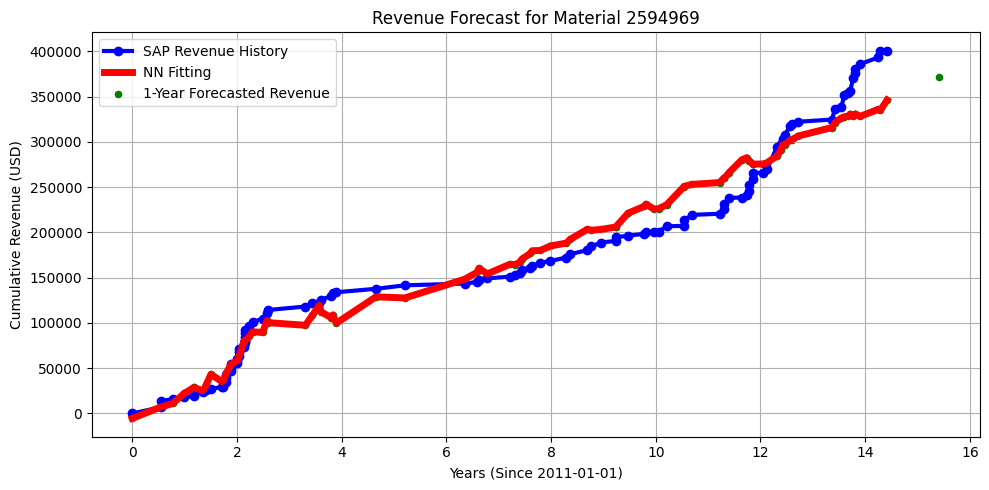

Material Quick Lookup: 2954320



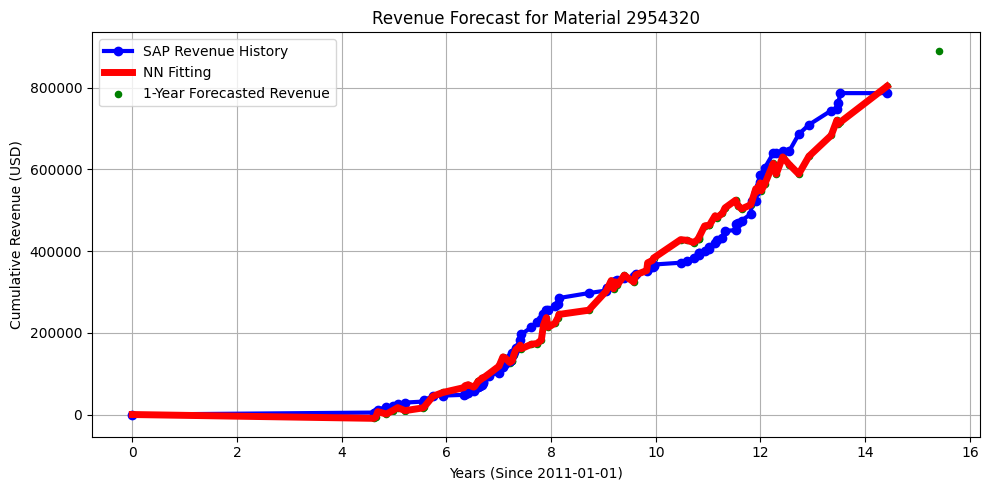

Material Quick Lookup: 2957190



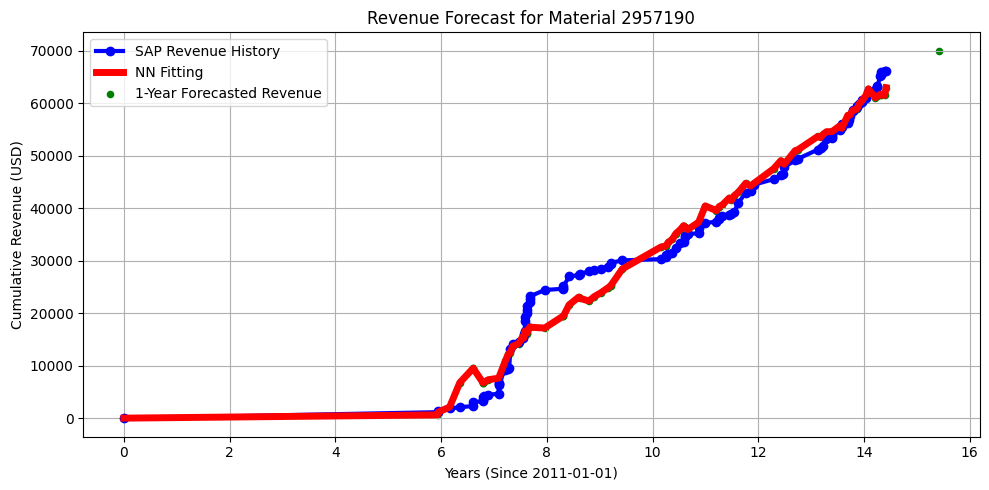

Material Quick Lookup: 2957265



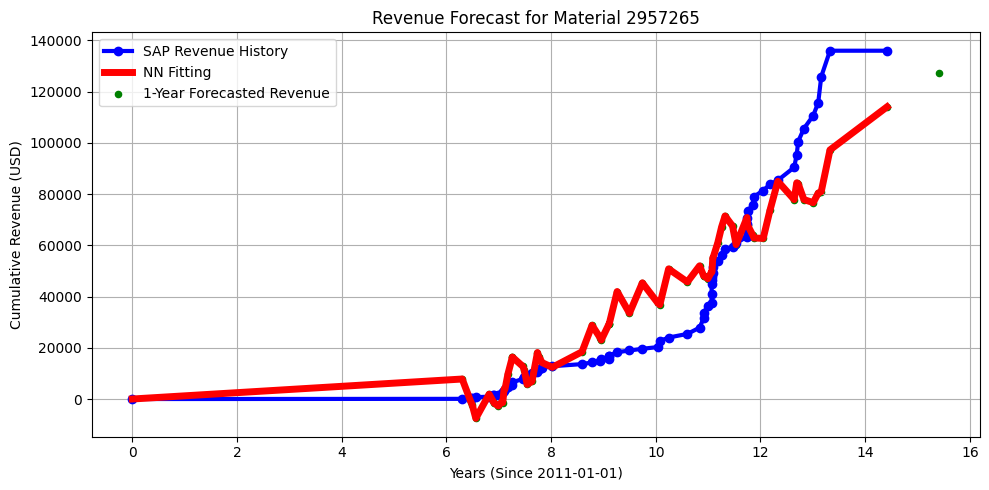

Material Quick Lookup: 2957266



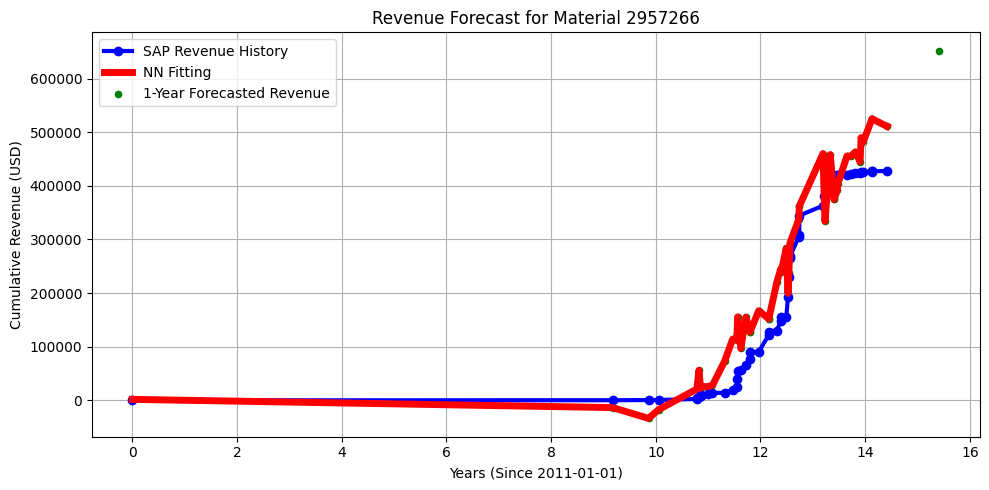

Material Quick Lookup: 2957267



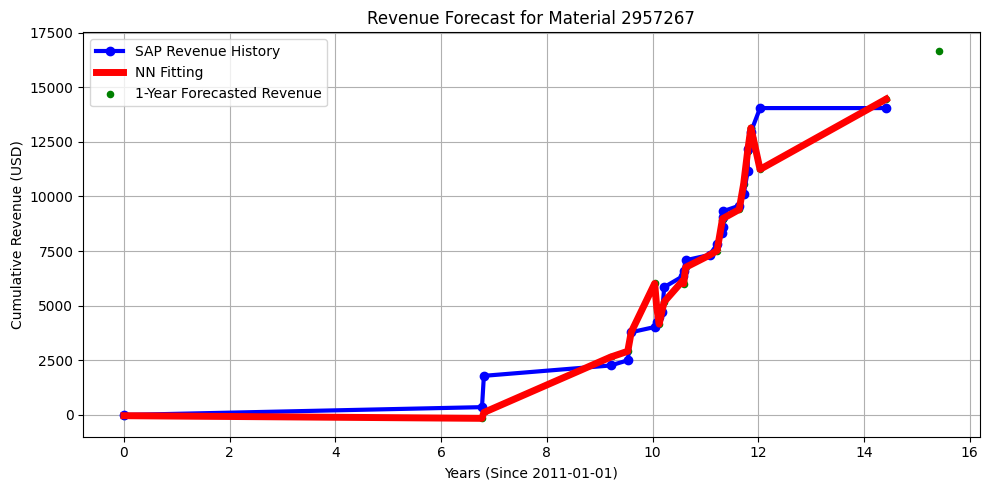

Material Quick Lookup: 2957268



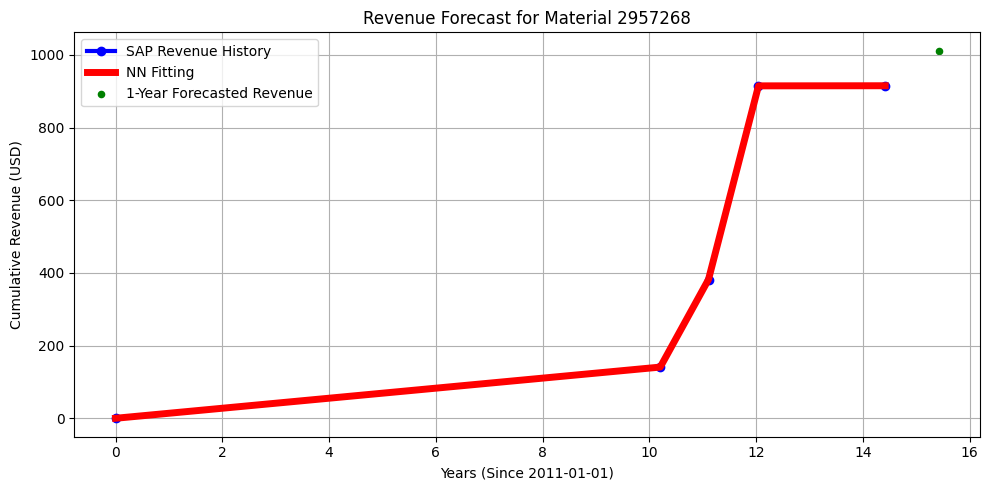

Material Quick Lookup: 2957269



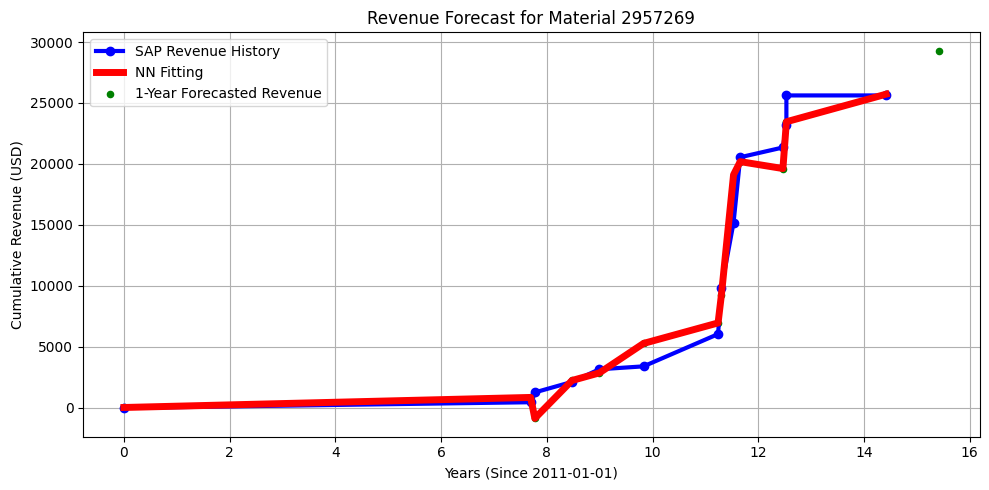

Material Quick Lookup: 2957270



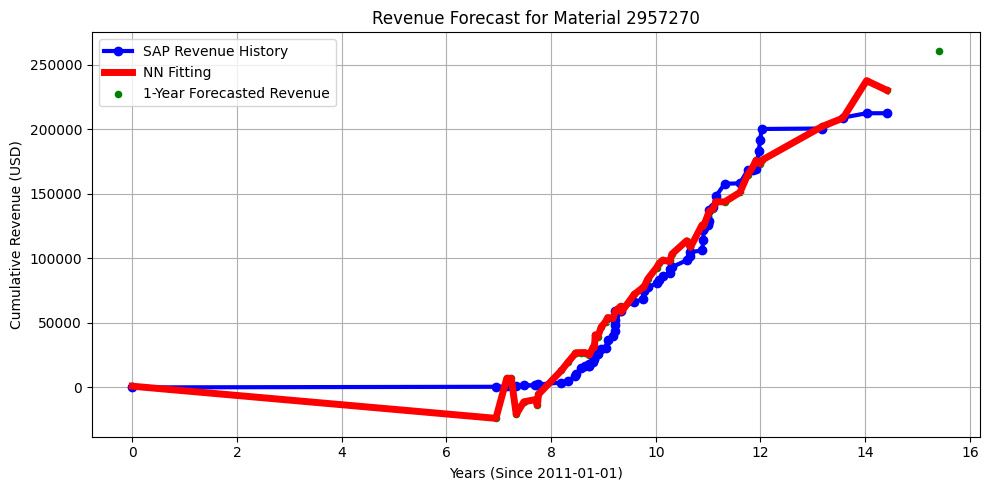

Material Quick Lookup: 2957272



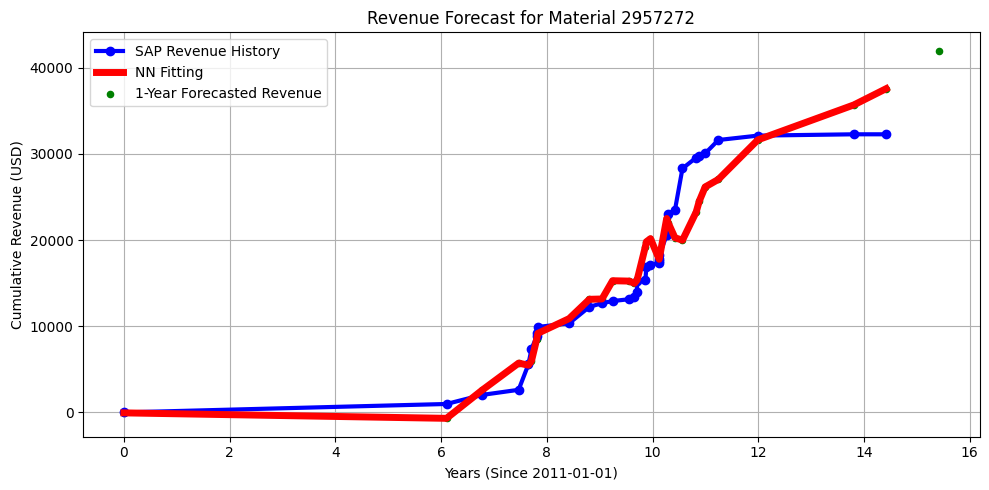

Material Quick Lookup: 2957273



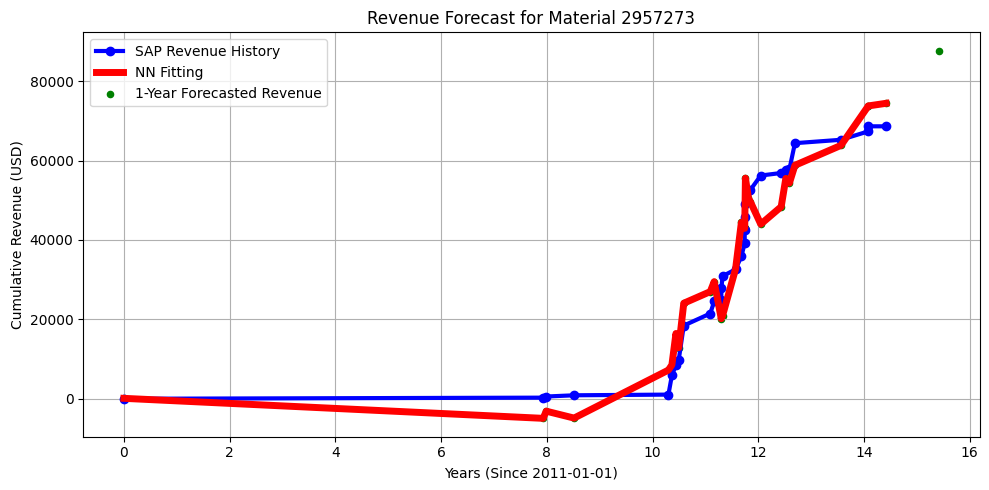

Material Quick Lookup: 2957274



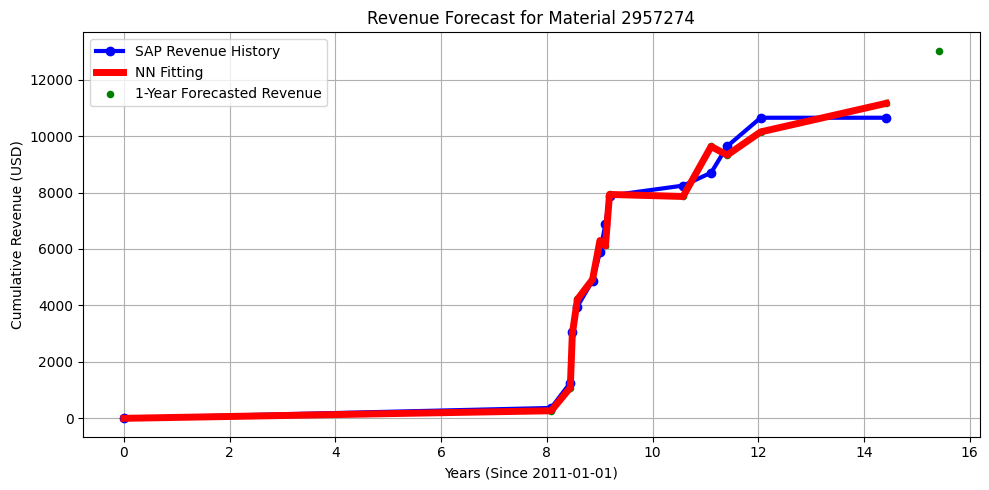

Material Quick Lookup: 2957275



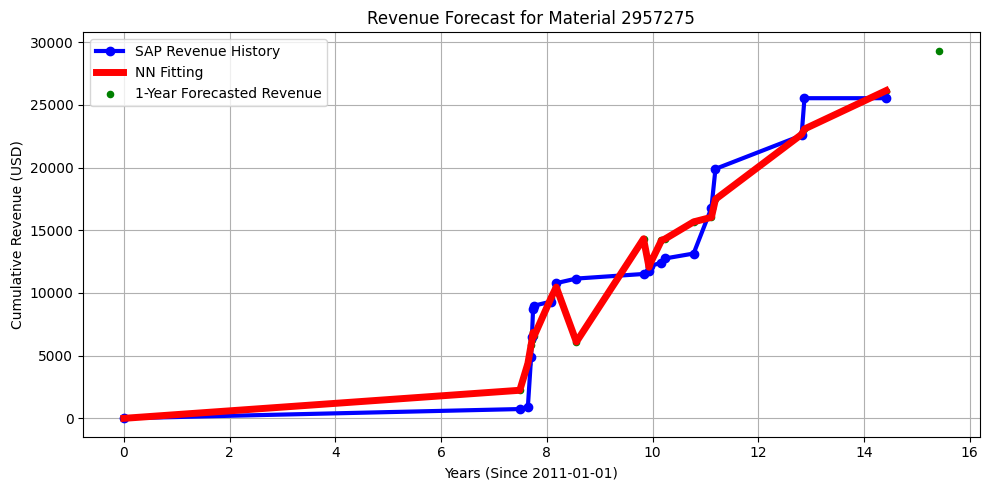

Material Quick Lookup: 2957276



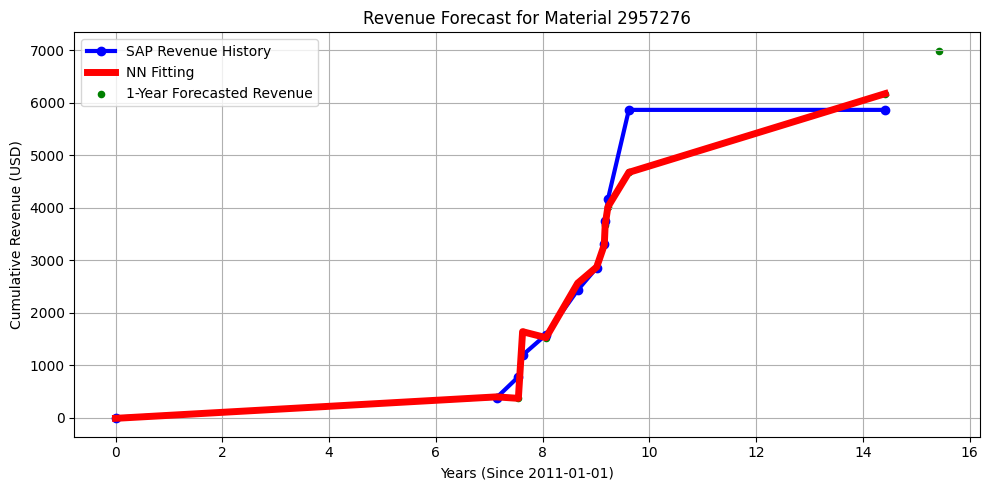

Material Quick Lookup: 2957277



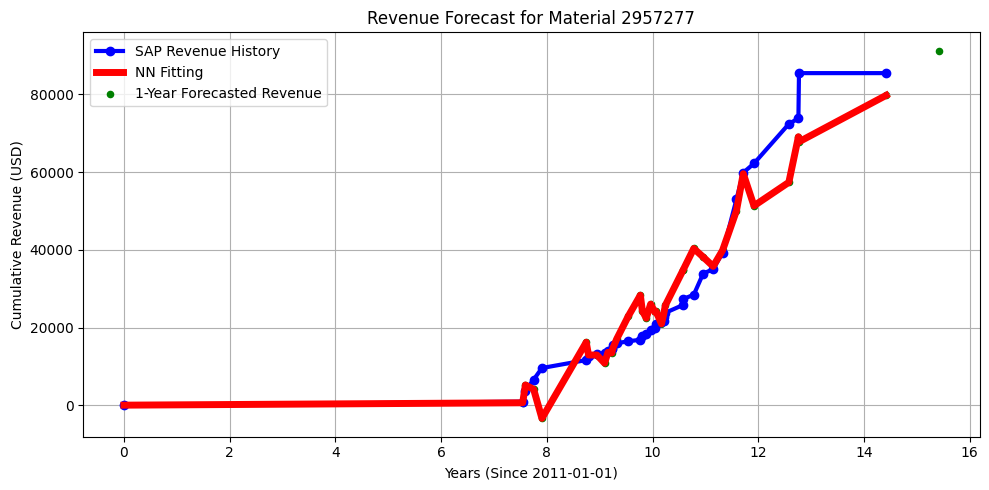

Material Quick Lookup: 2957278



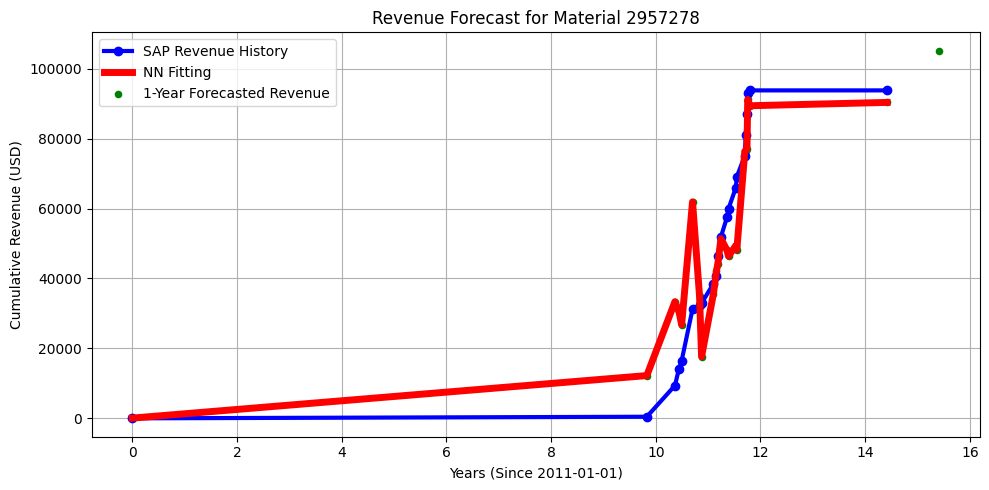

Material Quick Lookup: 2957279



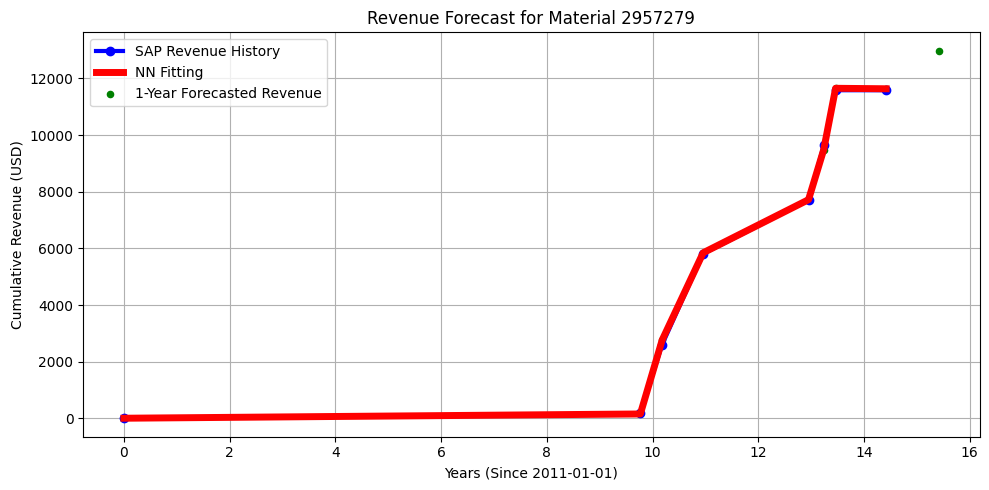

Material Quick Lookup: 2957281



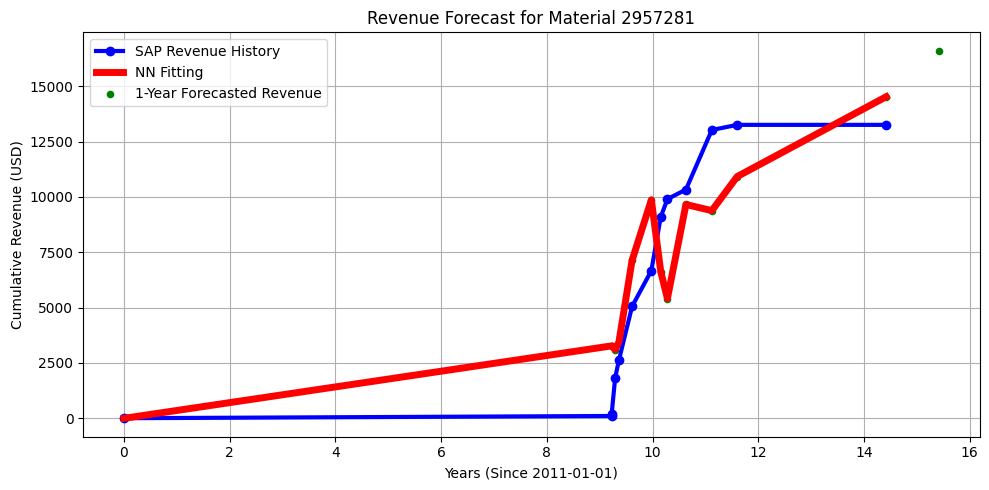

Material Quick Lookup: 2957284



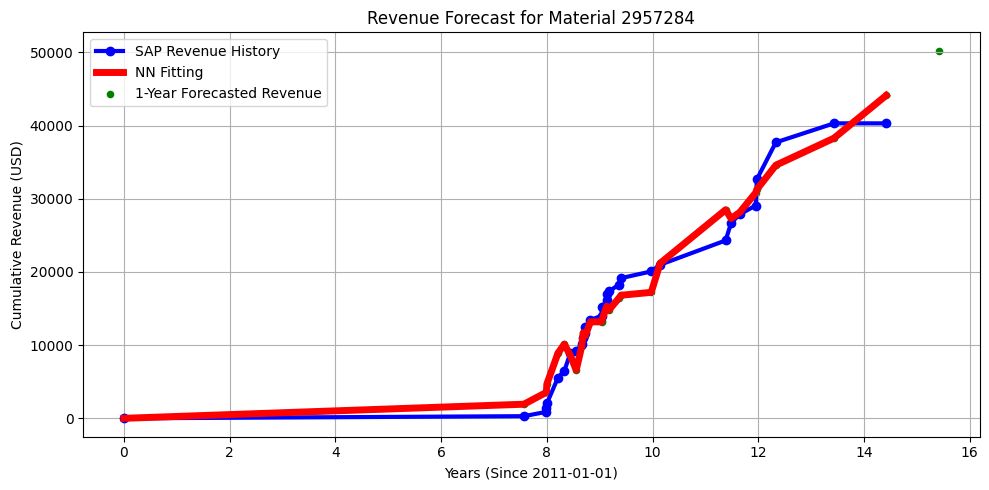

Material Quick Lookup: 2957285



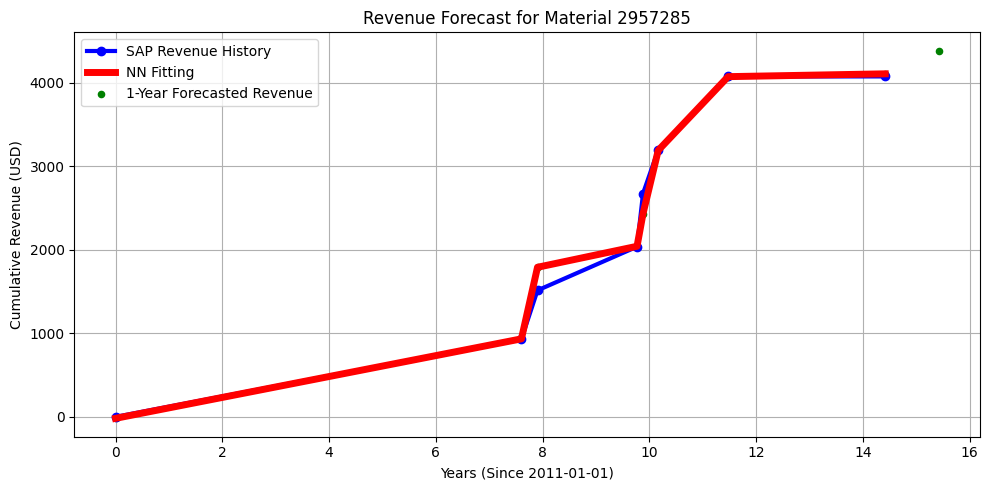

Material Quick Lookup: 2957286



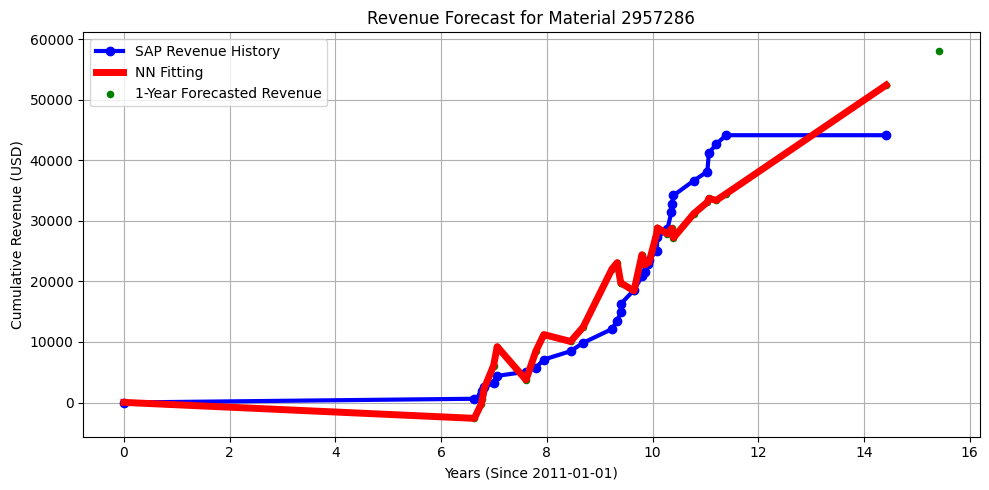

Material Quick Lookup: 2957287



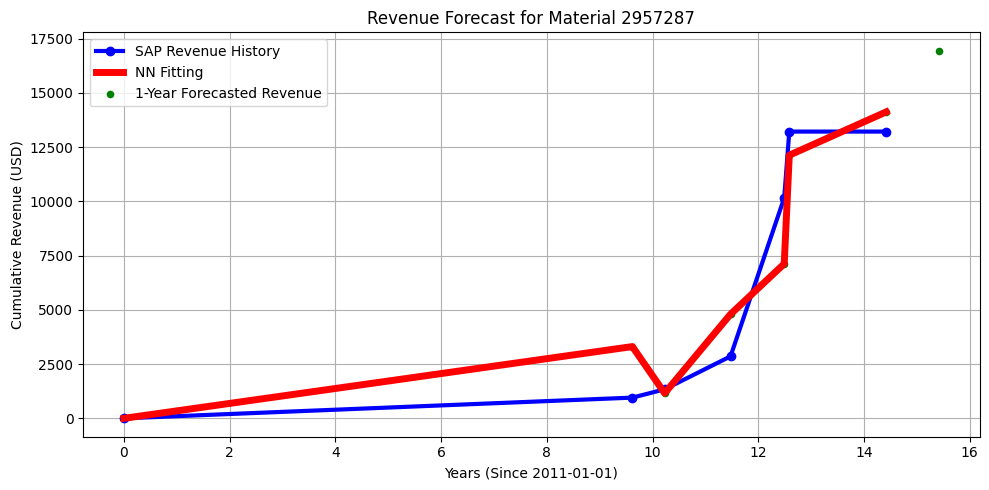

Material Quick Lookup: 2957427



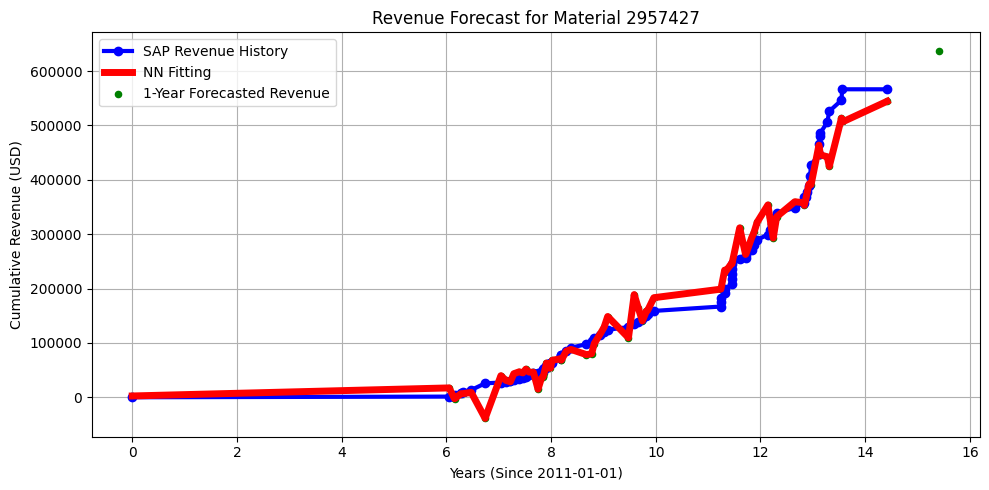

Material Quick Lookup: 2957470



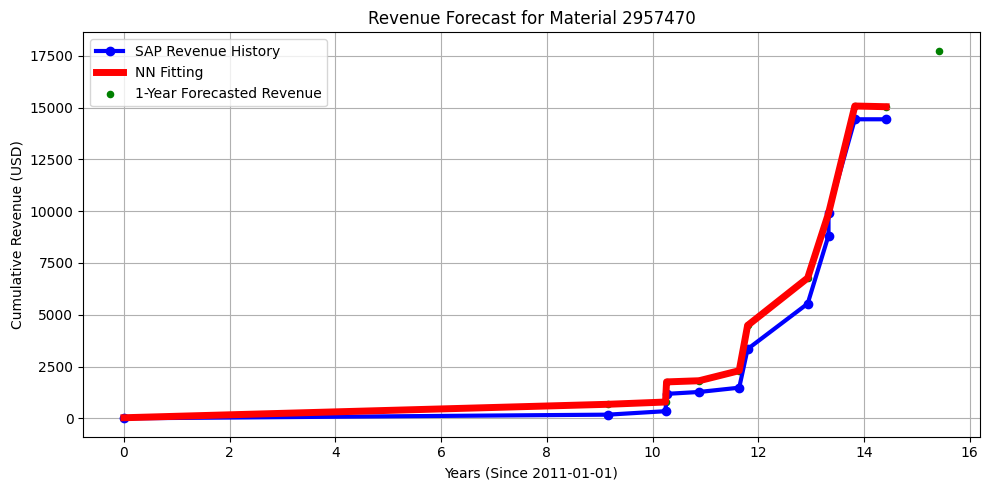

Material Quick Lookup: 2957478



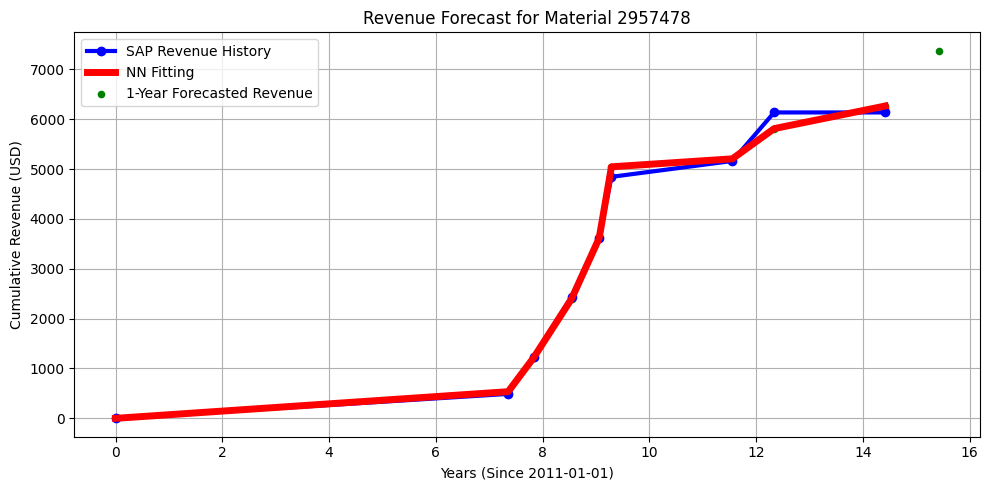

Material Quick Lookup: 2957483



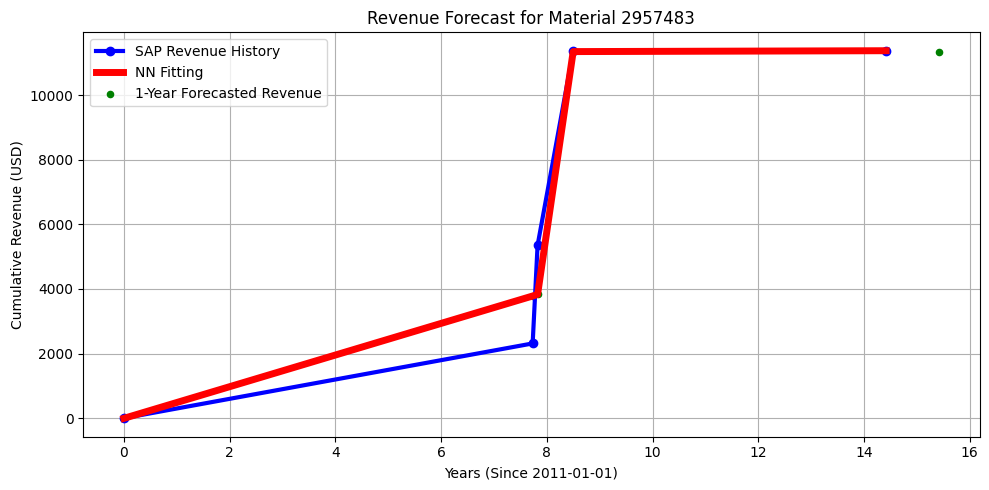

Material Quick Lookup: 2957519



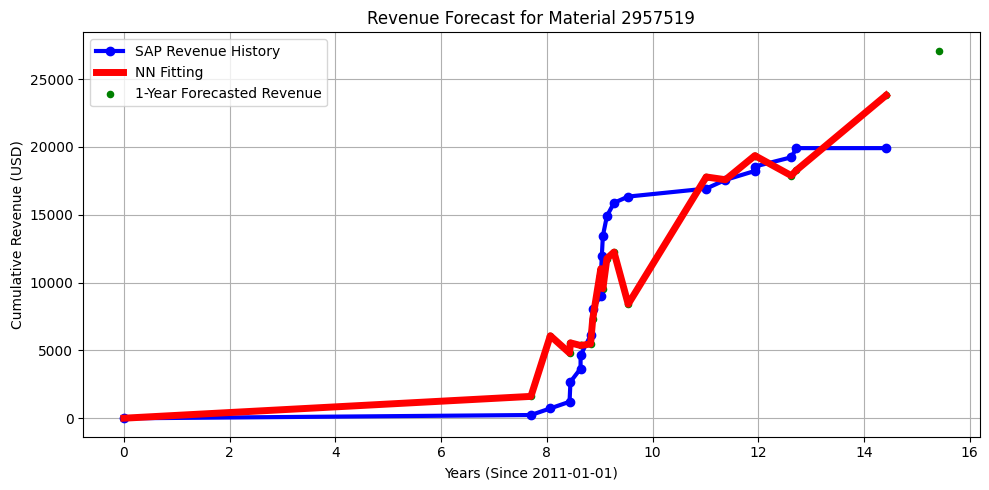

Material Quick Lookup: 2957525



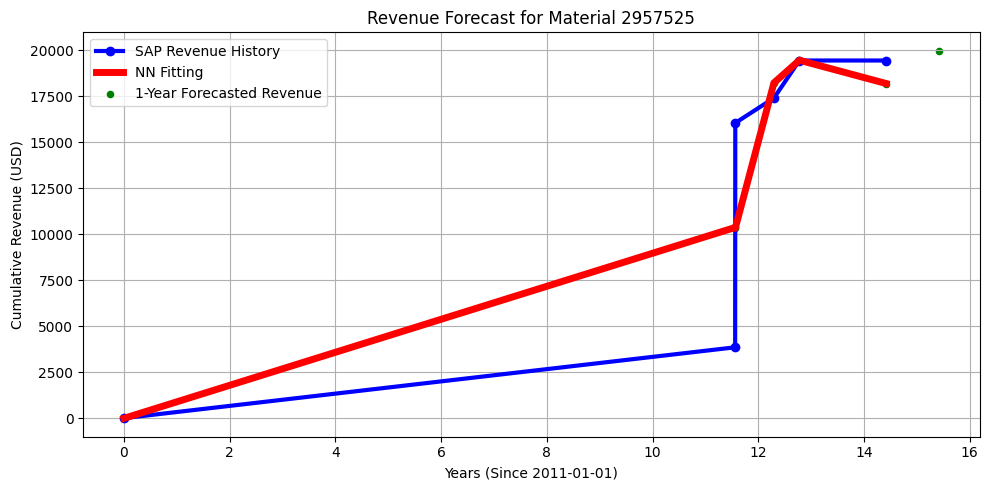

Material Quick Lookup: 2958046



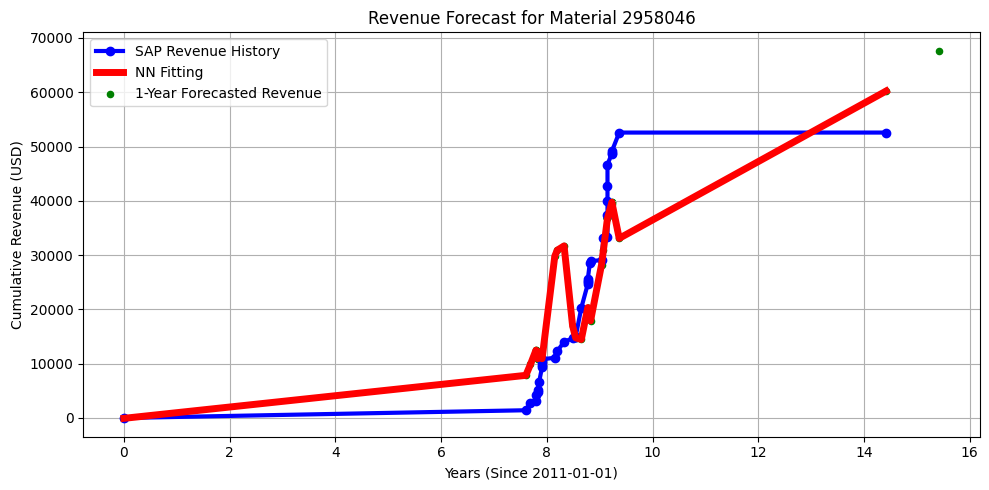

Material Quick Lookup: 2958084



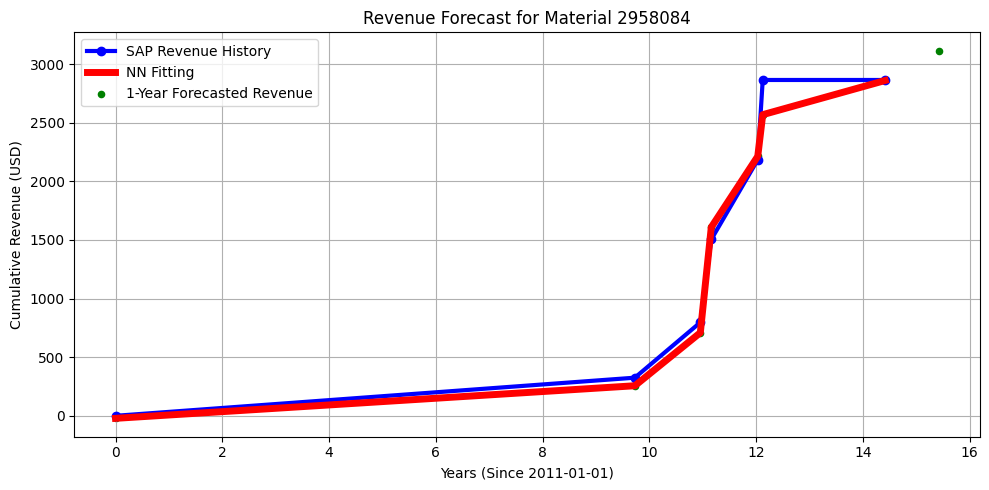

Material Quick Lookup: 2958106



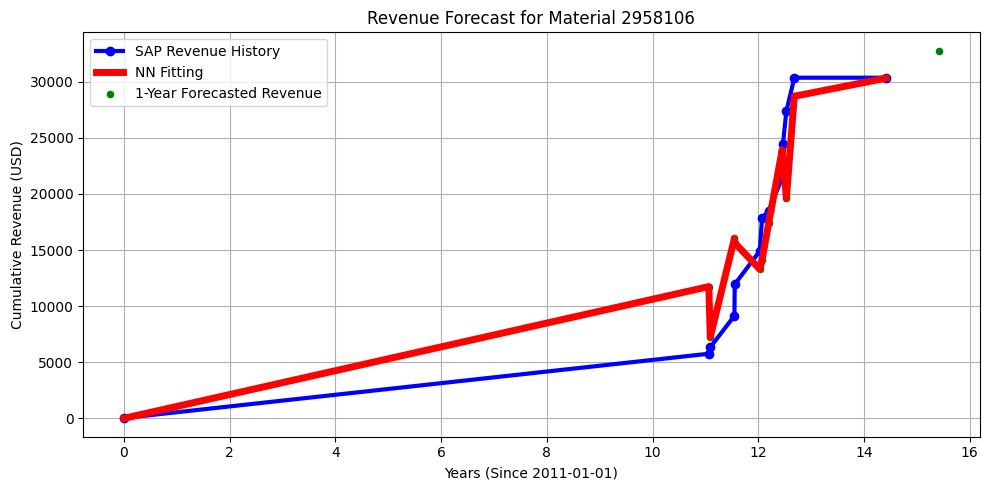

Material Quick Lookup: 2958130



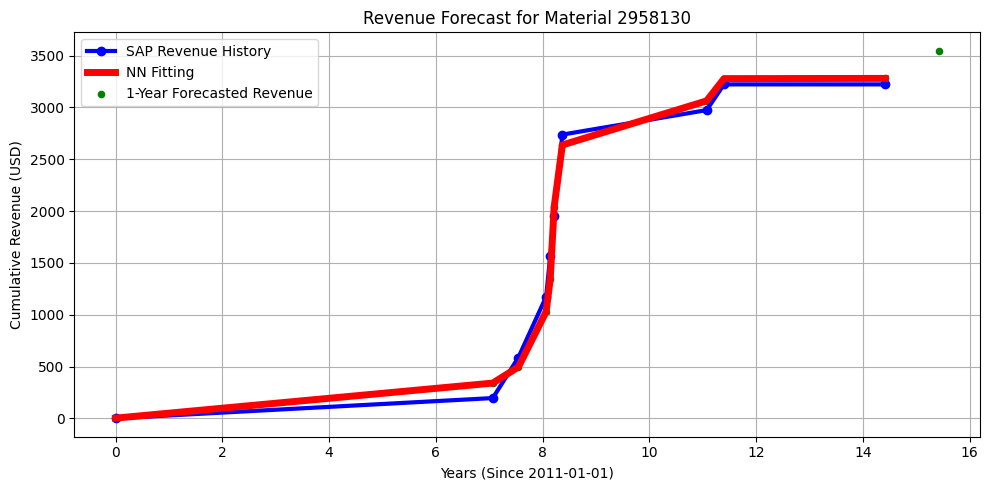

Material Quick Lookup: 2958300



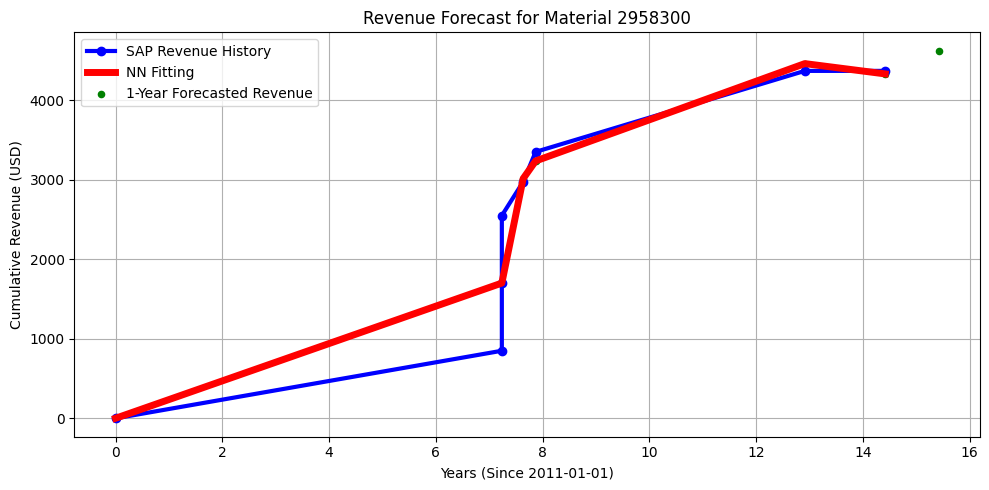

Material Quick Lookup: 2958343



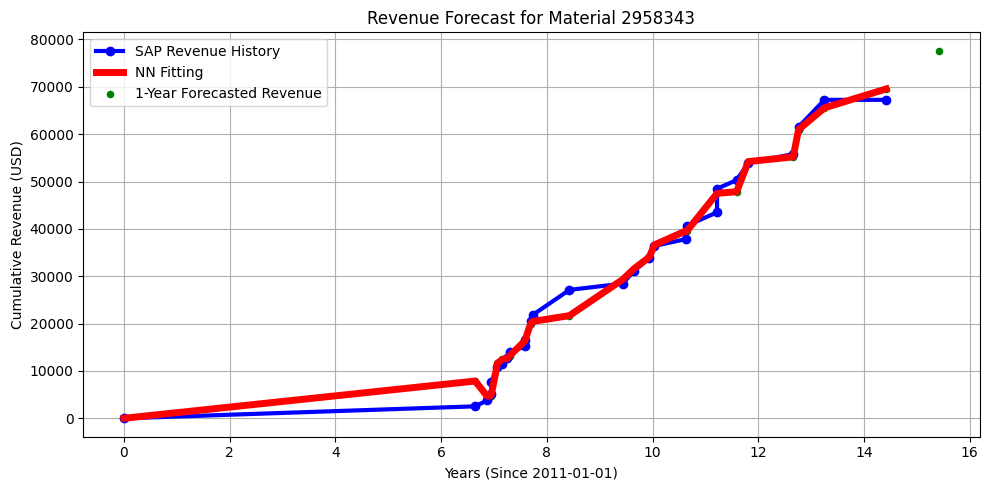

Material Quick Lookup: 2958408



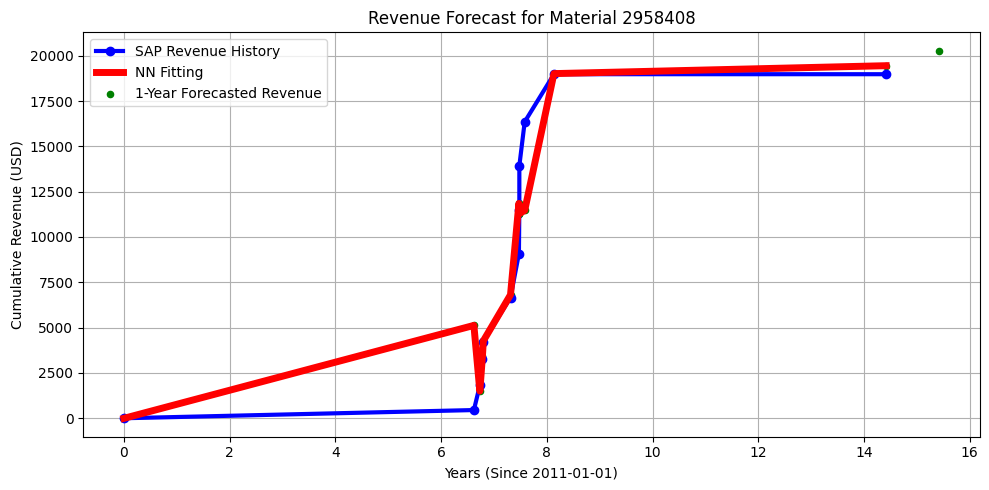

Material Quick Lookup: 2958424



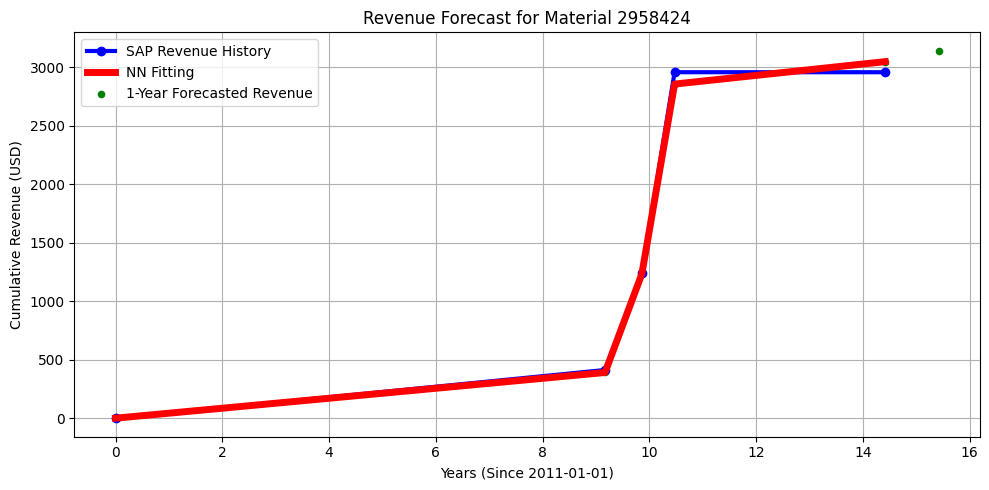

Material Quick Lookup: 2958815



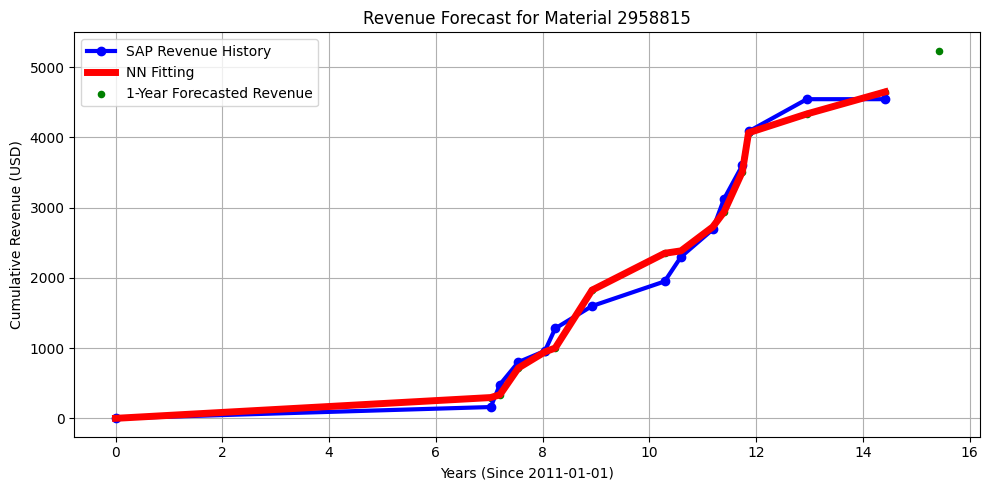

Material Quick Lookup: 2958817



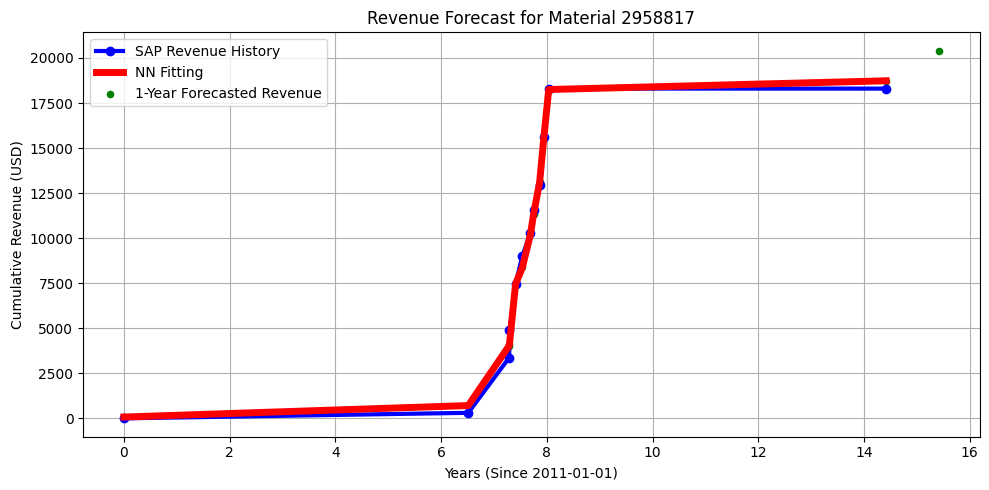

Material Quick Lookup: 2959032



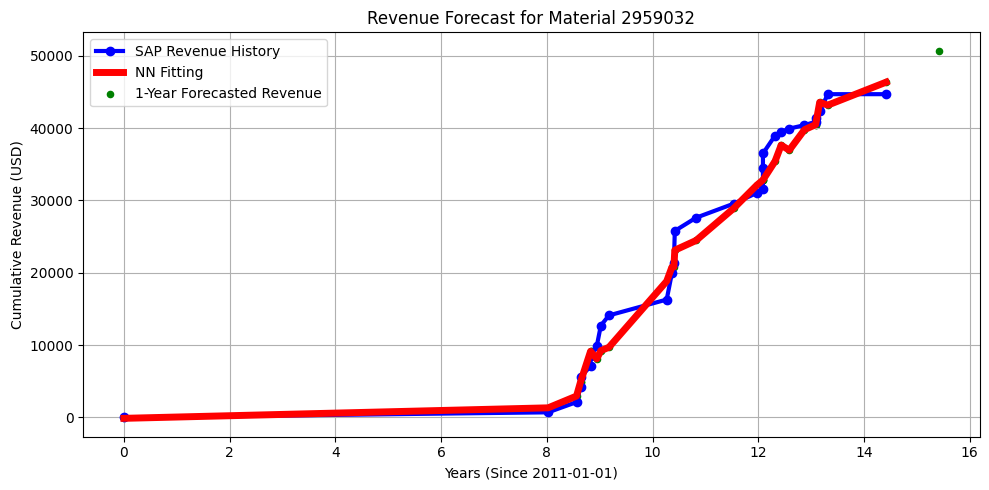

Material Quick Lookup: 2959151



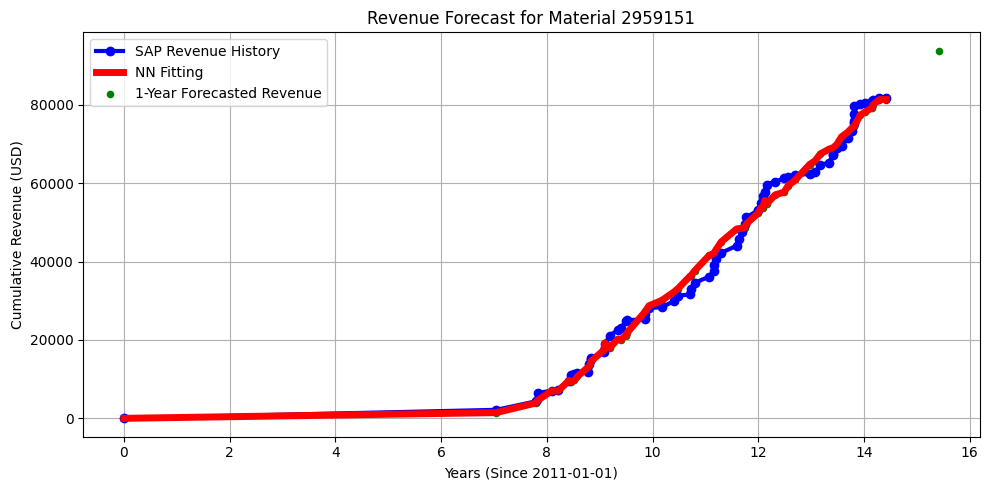

Material Quick Lookup: 2959707



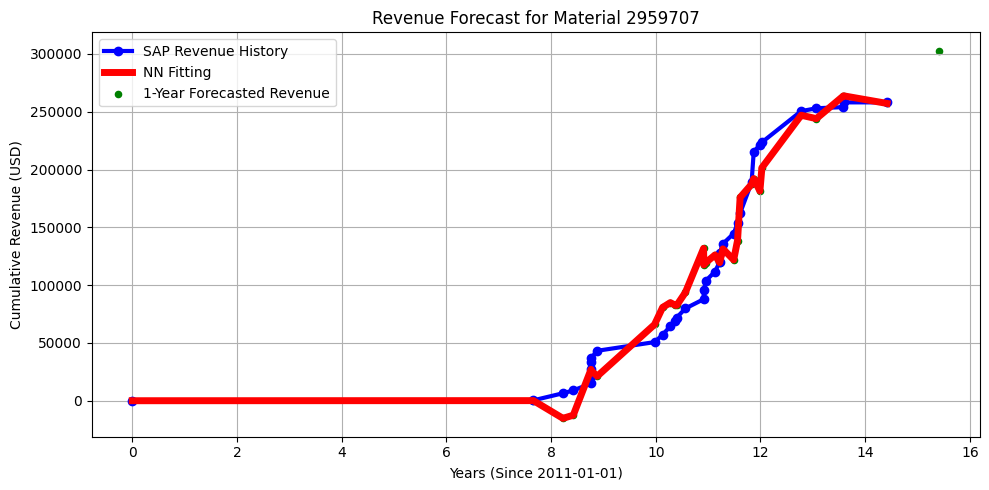

Material Quick Lookup: 7510230



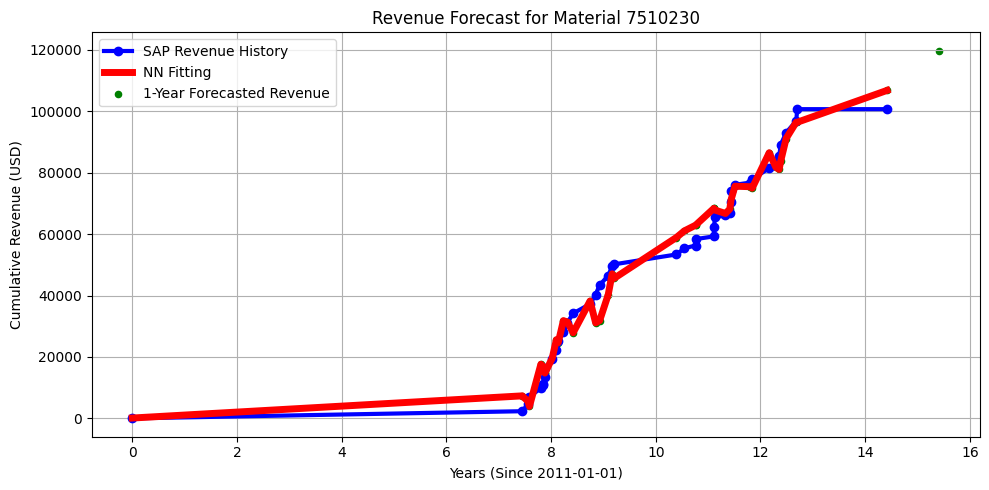

Material Quick Lookup: 7510231



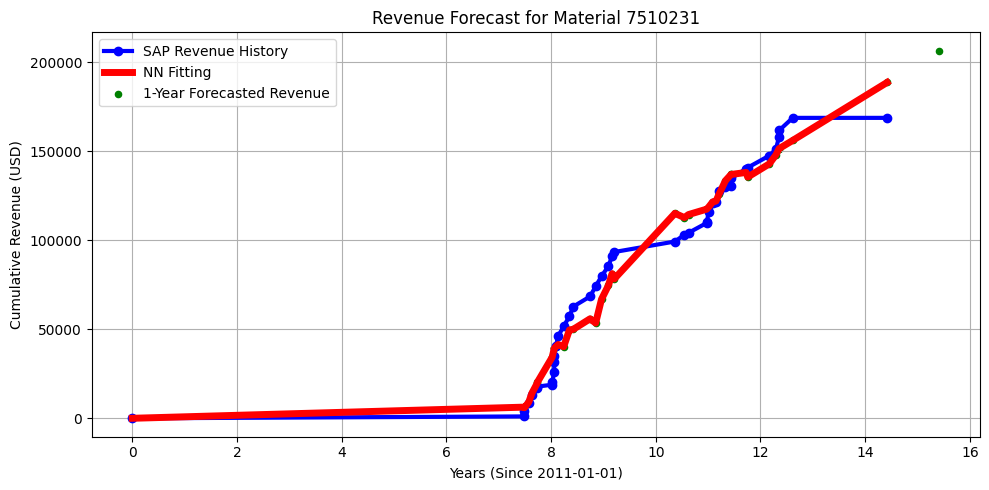

Material Quick Lookup: 7701239



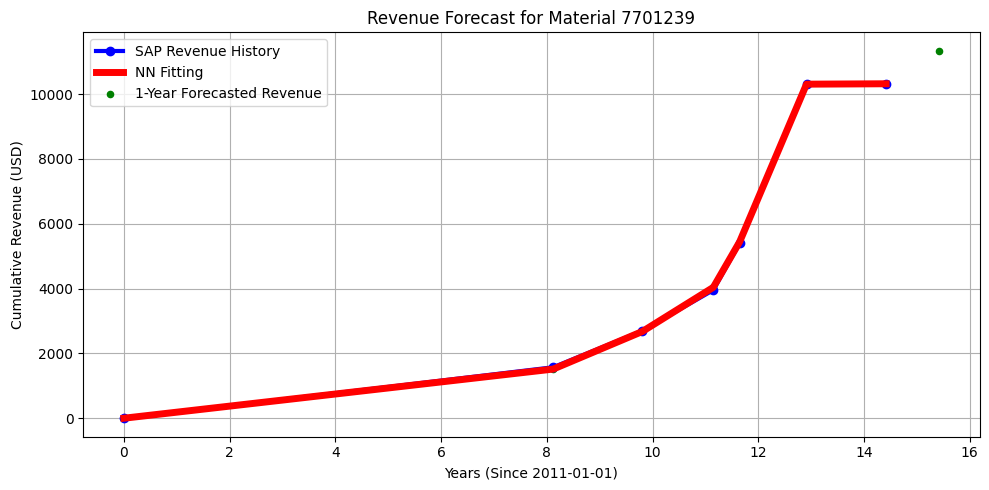

Material Quick Lookup: 7701761



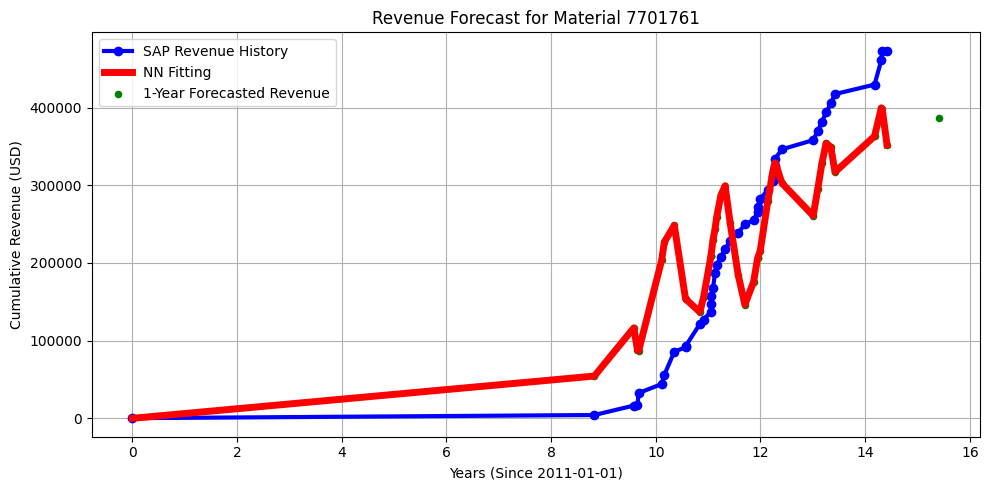

Material Quick Lookup: 7701880



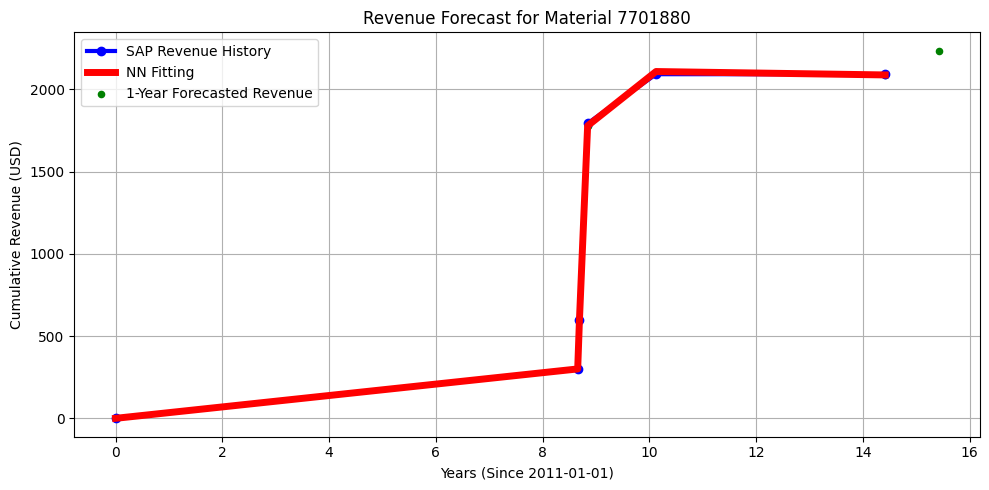

Material Quick Lookup: 7701884



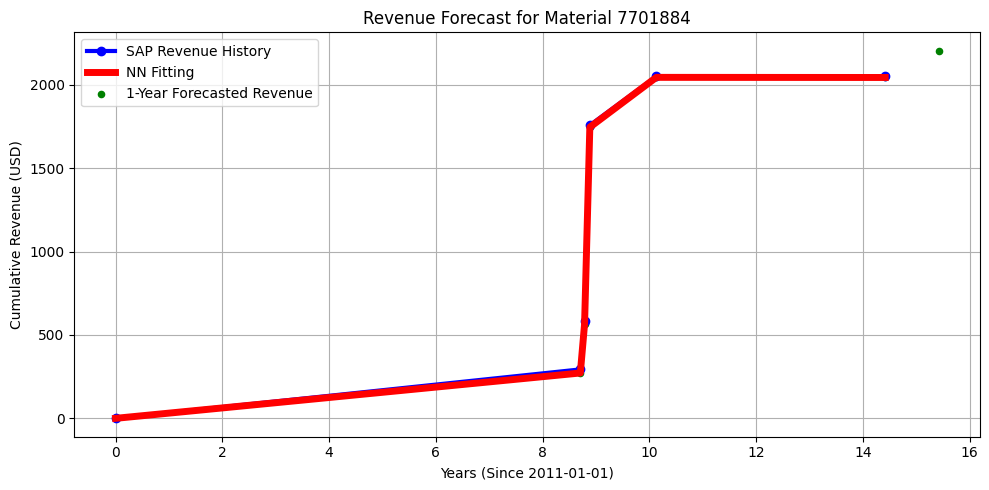

Material Quick Lookup: 7702108



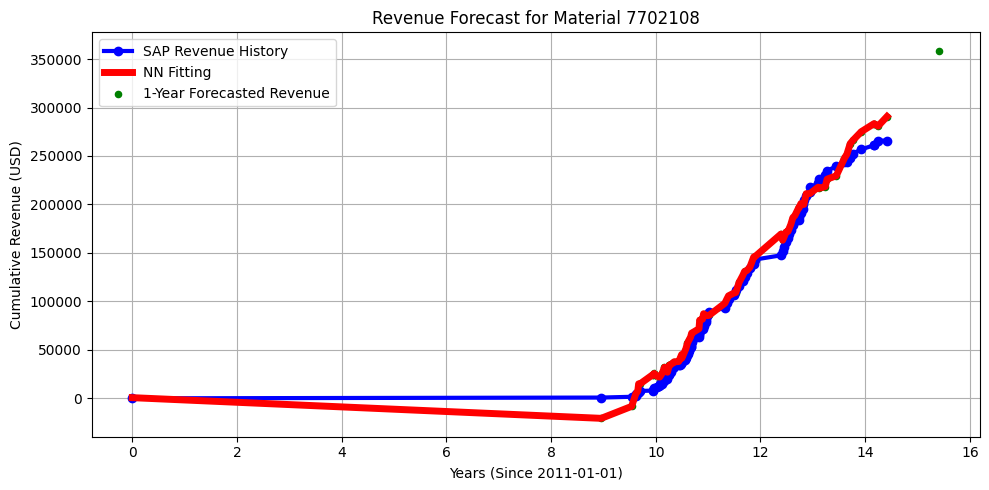

Material Quick Lookup: 7702109



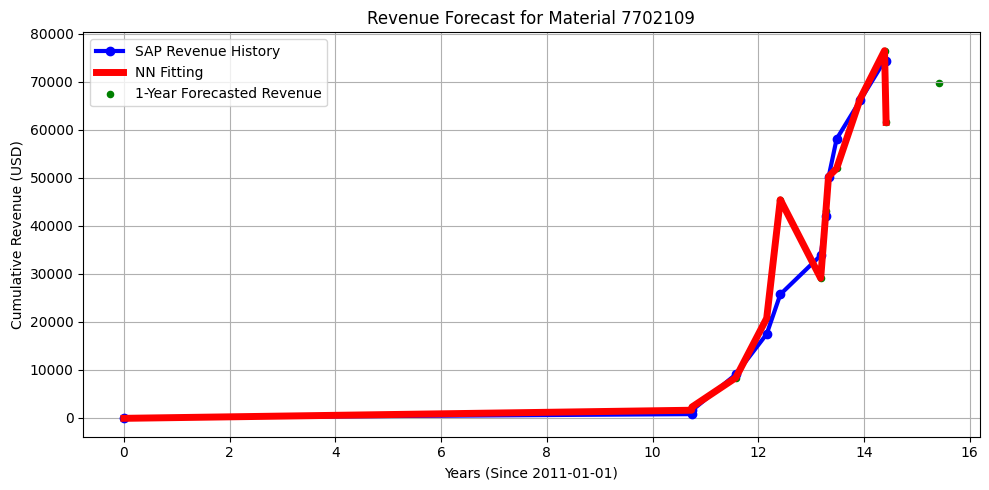

Material Quick Lookup: 7702111



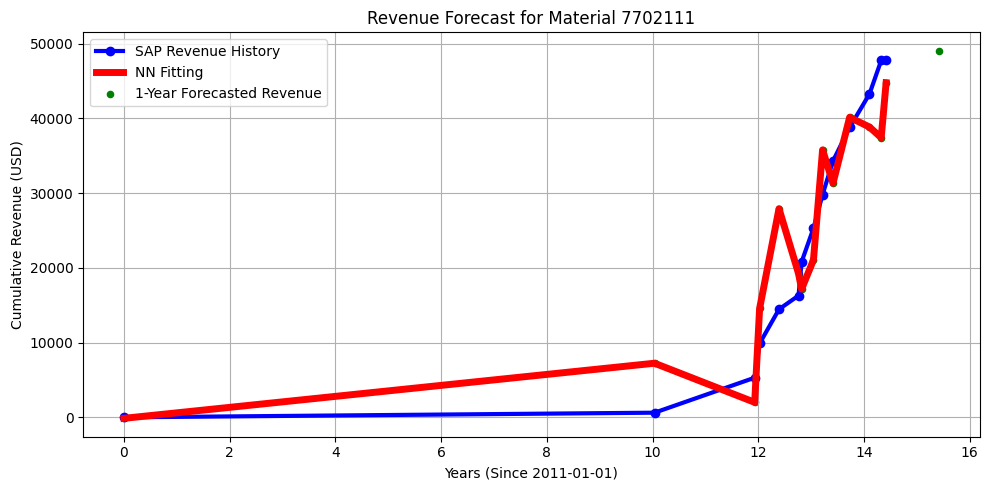

Material Quick Lookup: 7702264



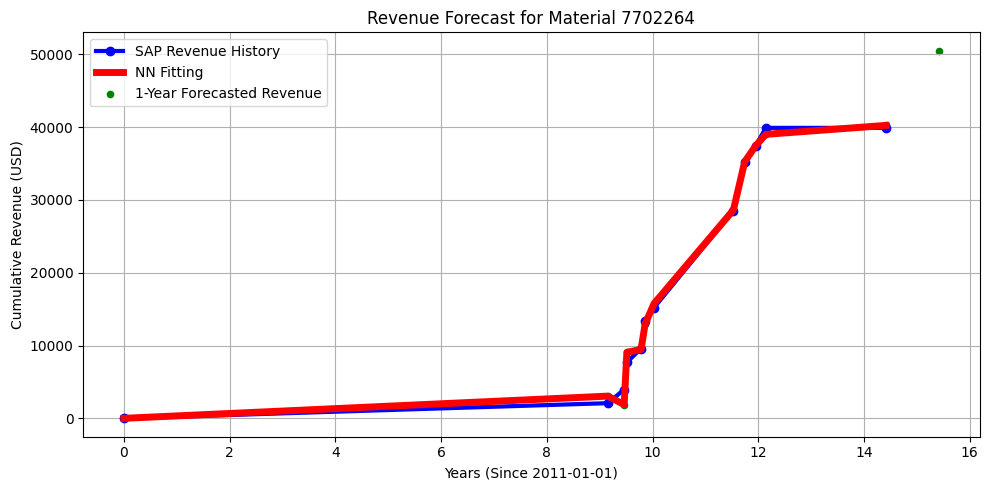

Material Quick Lookup: 7702269



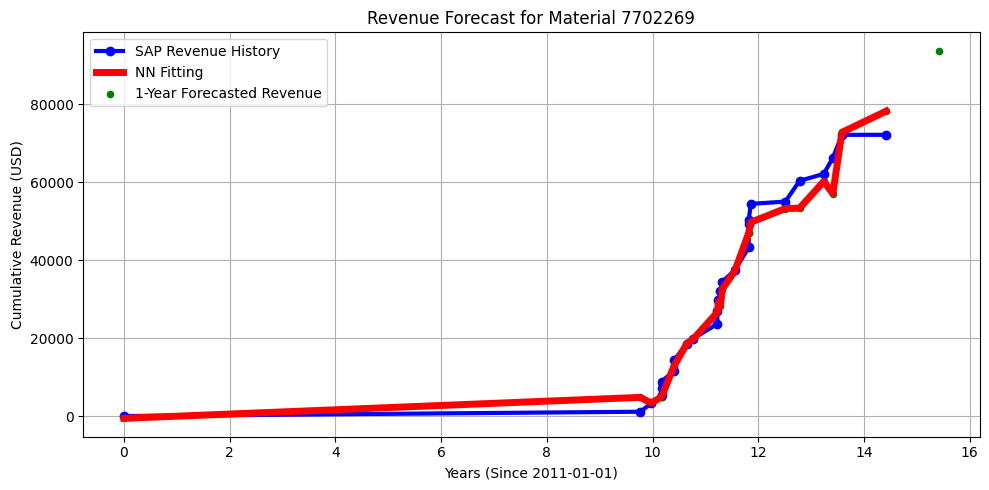

Material Quick Lookup: 7702362



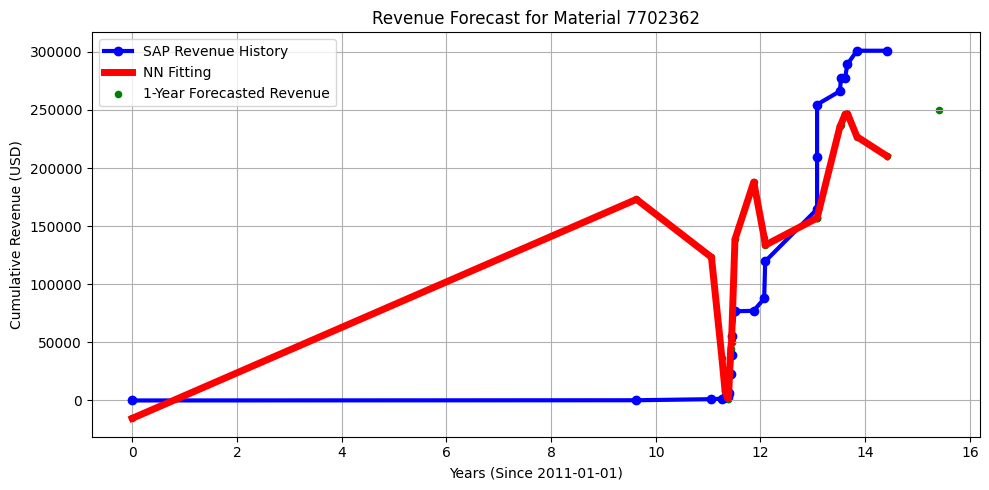

Material Quick Lookup: 7702699



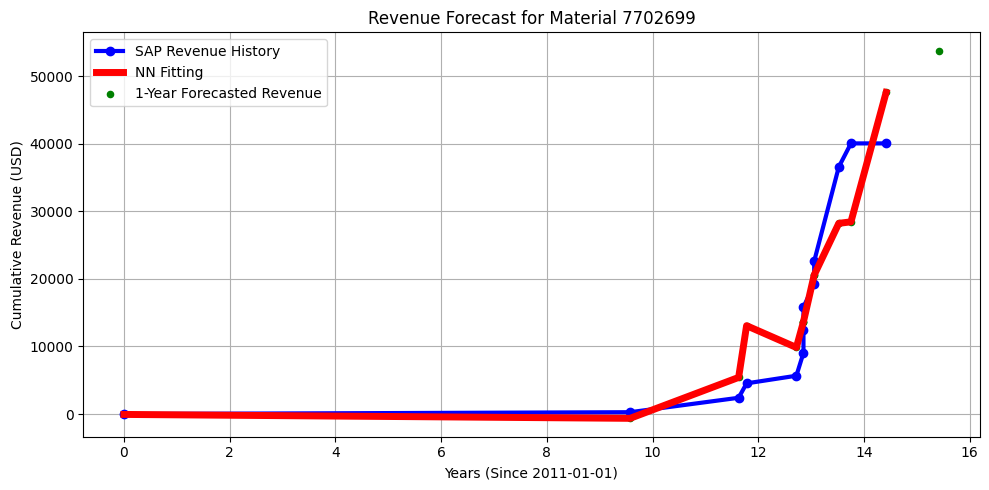

Material Quick Lookup: 7702867



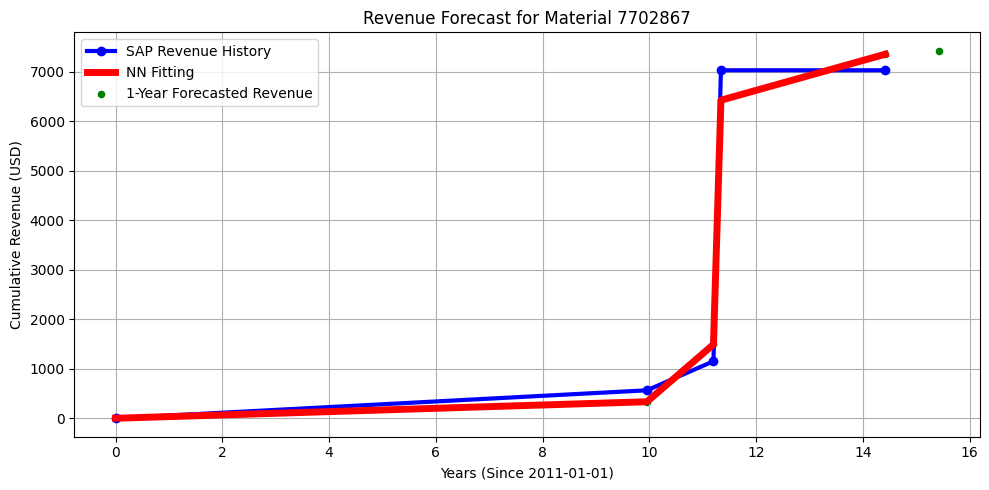

Material Quick Lookup: 7702914



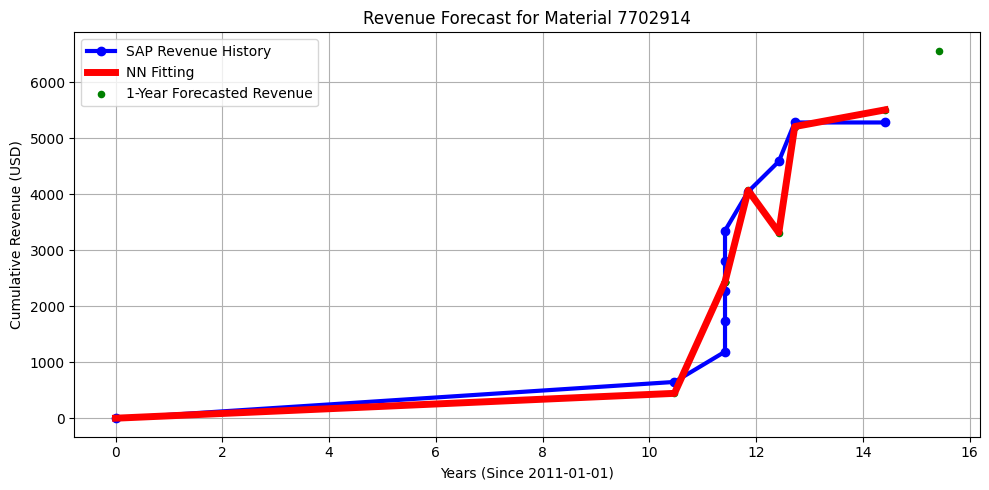

Material Quick Lookup: 7703247



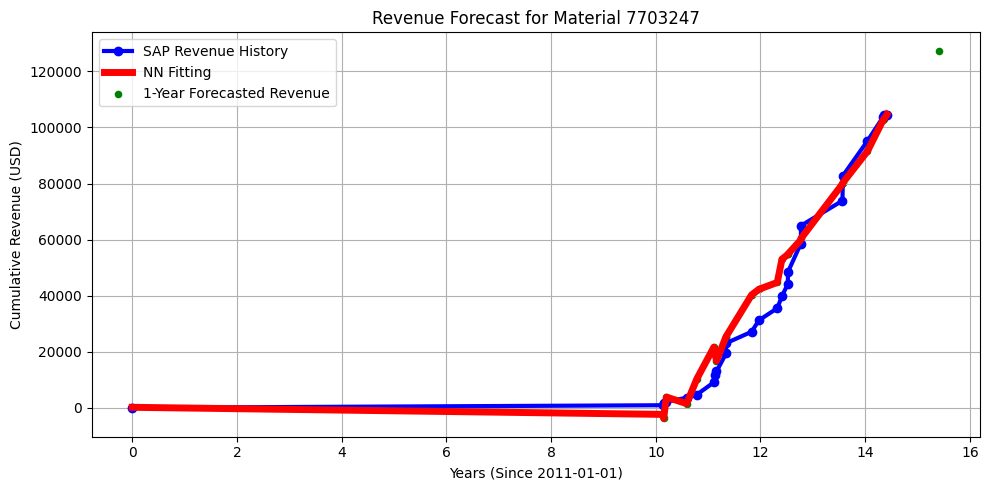

Material Quick Lookup: 7703373



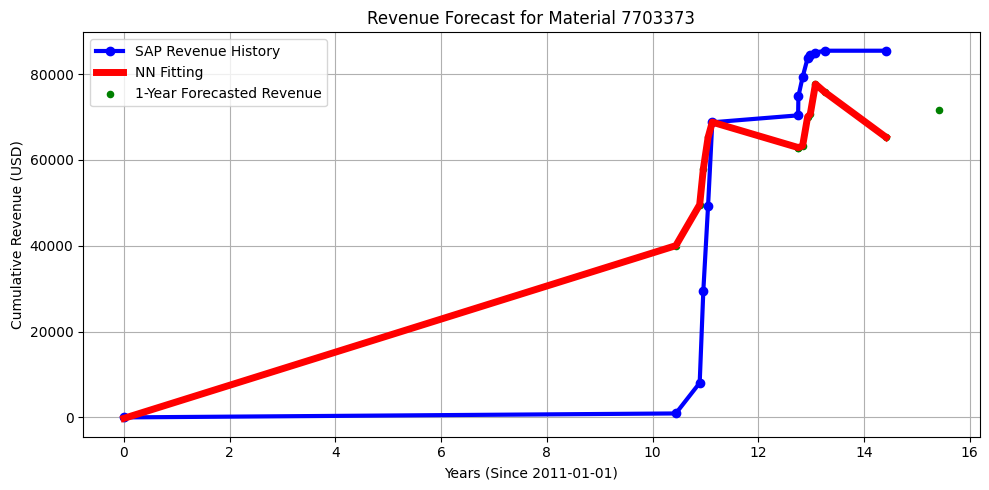

Material Quick Lookup: 7703437



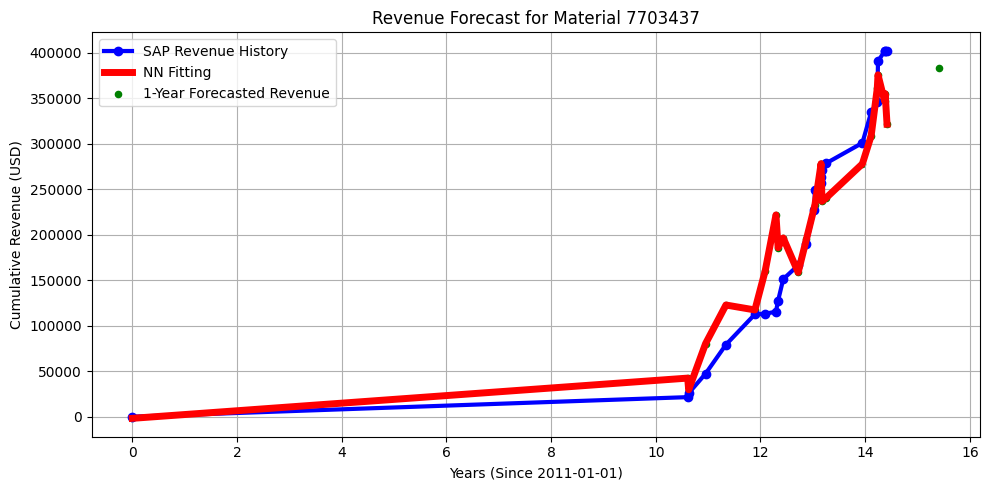

Material Quick Lookup: 7704164



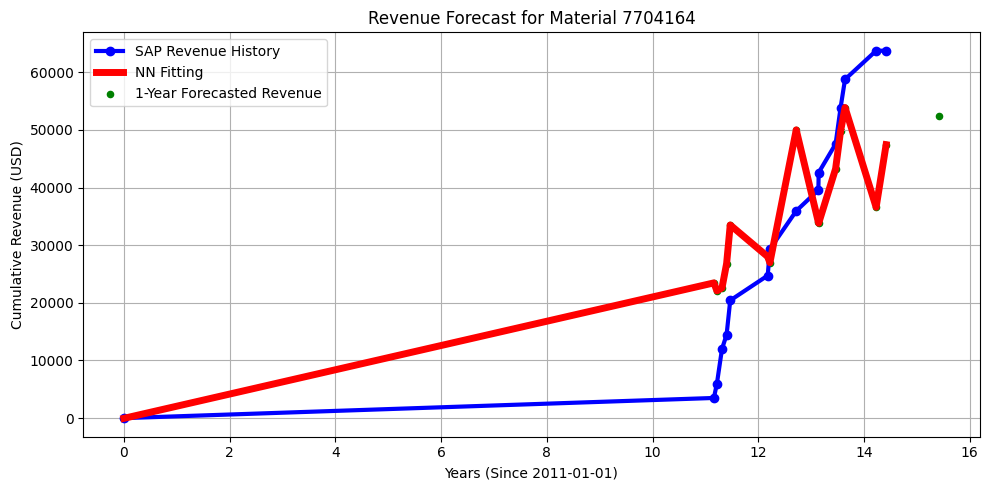

Material Quick Lookup: 7704292



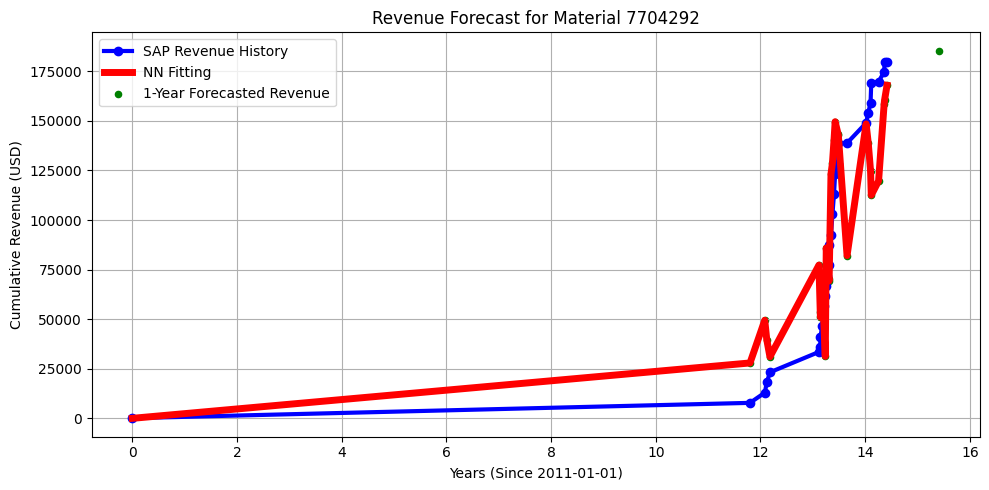

Material Quick Lookup: 7704535



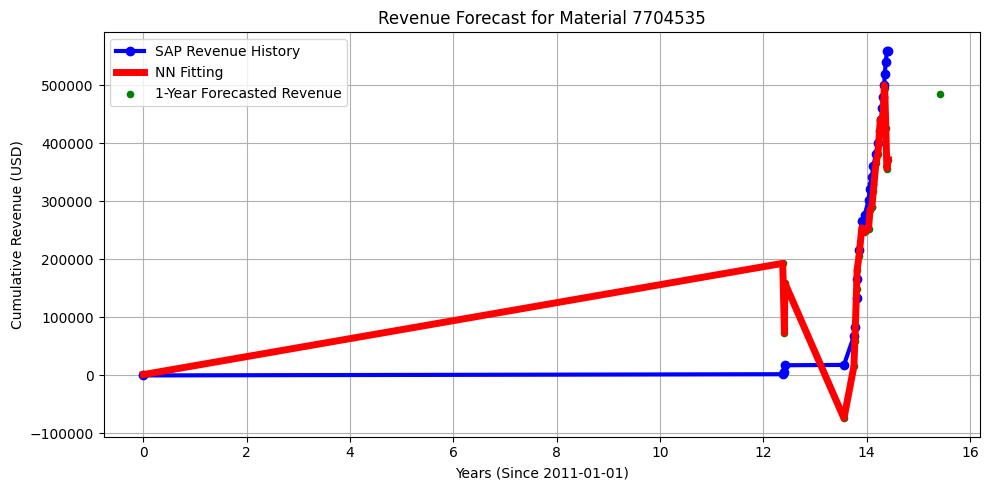

Material Quick Lookup: 7704968



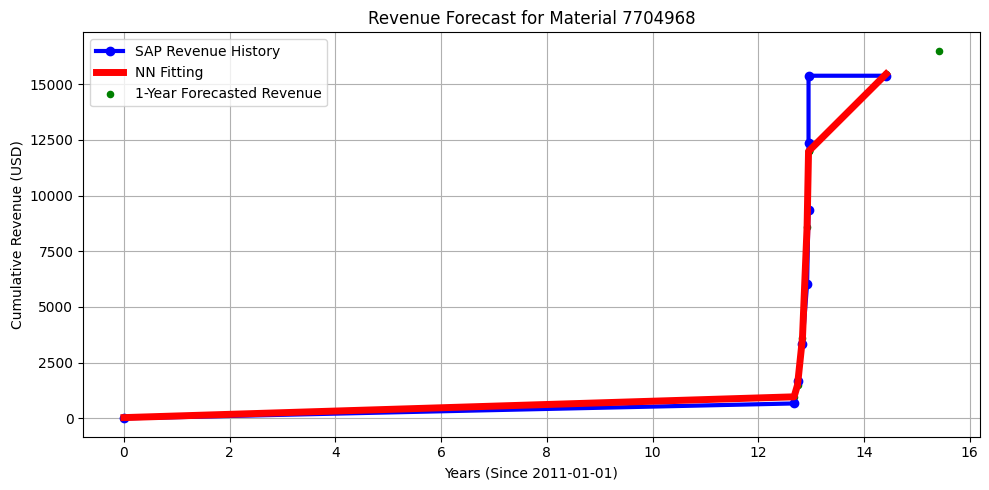

Material Quick Lookup: 7704969



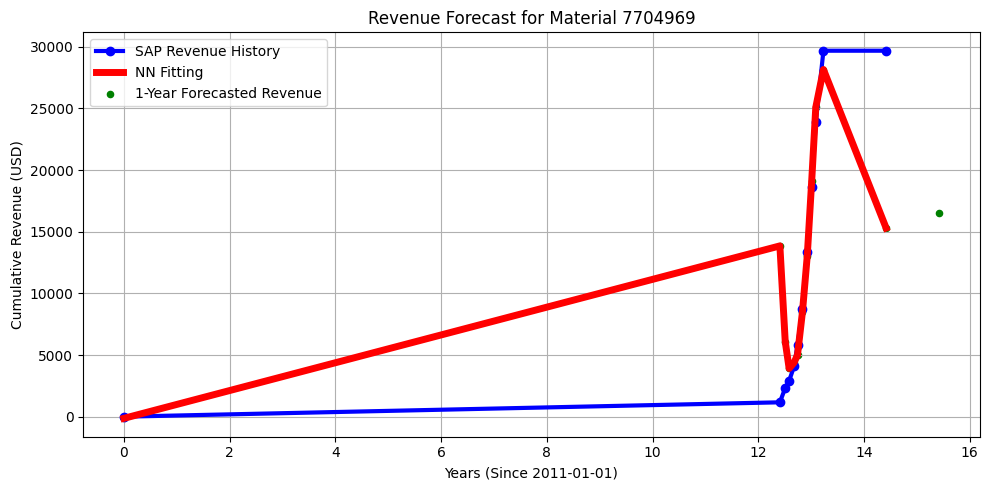

Material Quick Lookup: 7705024



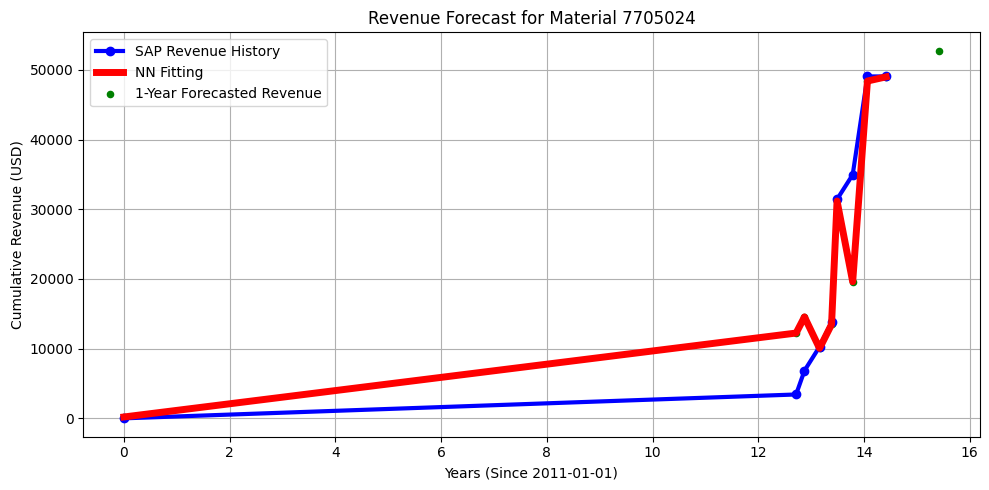

Material Quick Lookup: 7705025



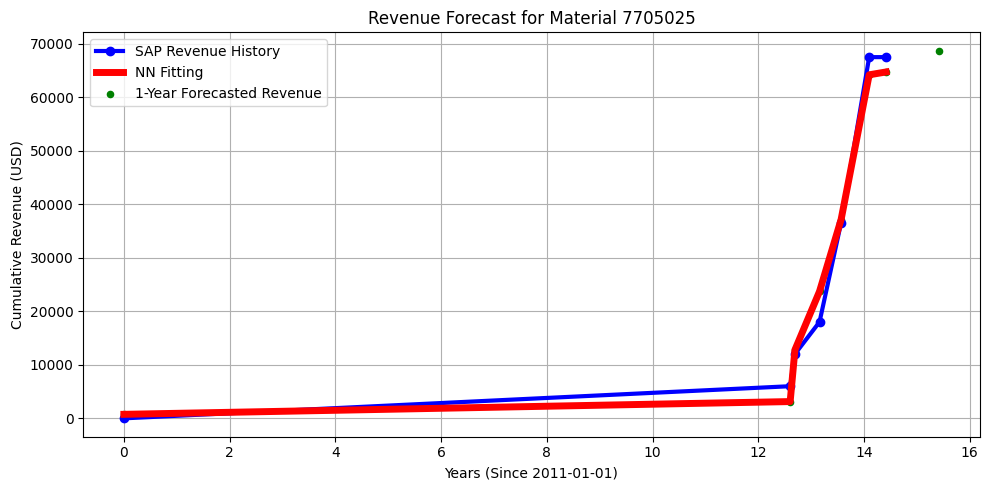

Material Quick Lookup: 7705145



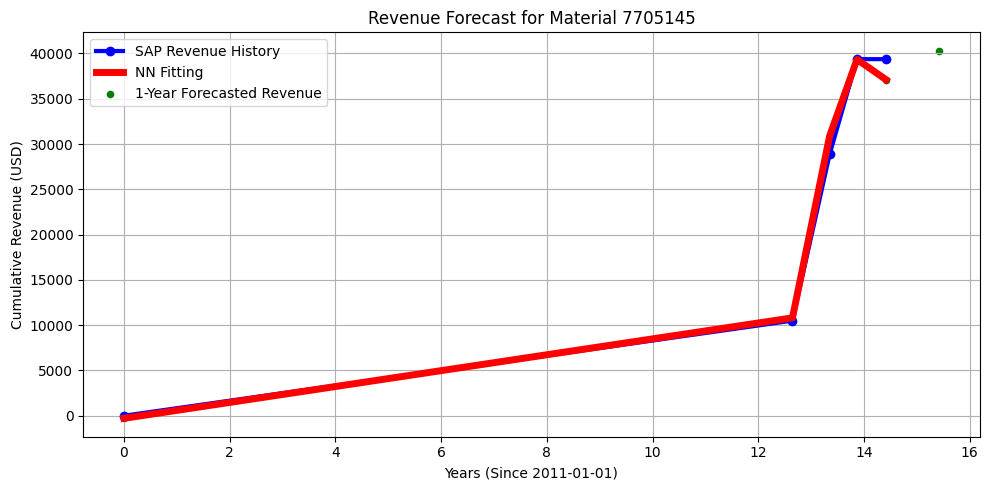

Material Quick Lookup: 7705492



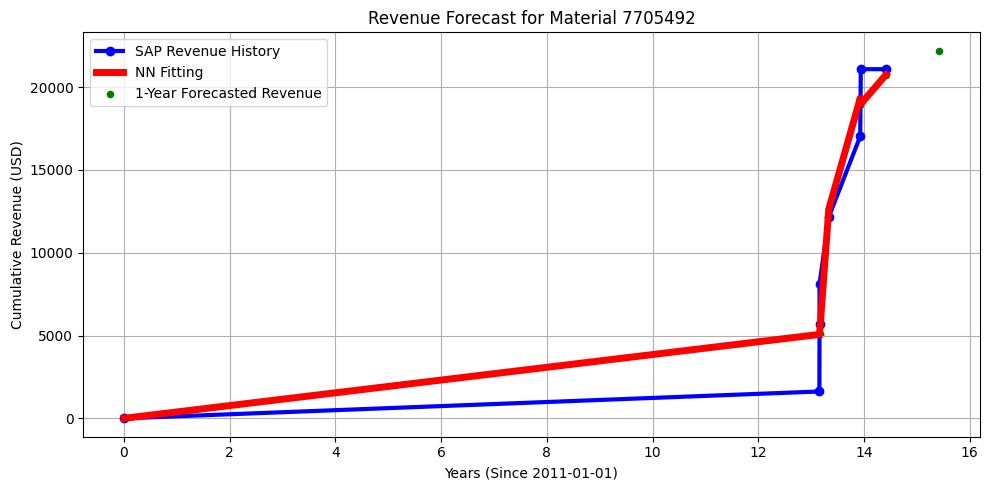

Material Quick Lookup: 7706802



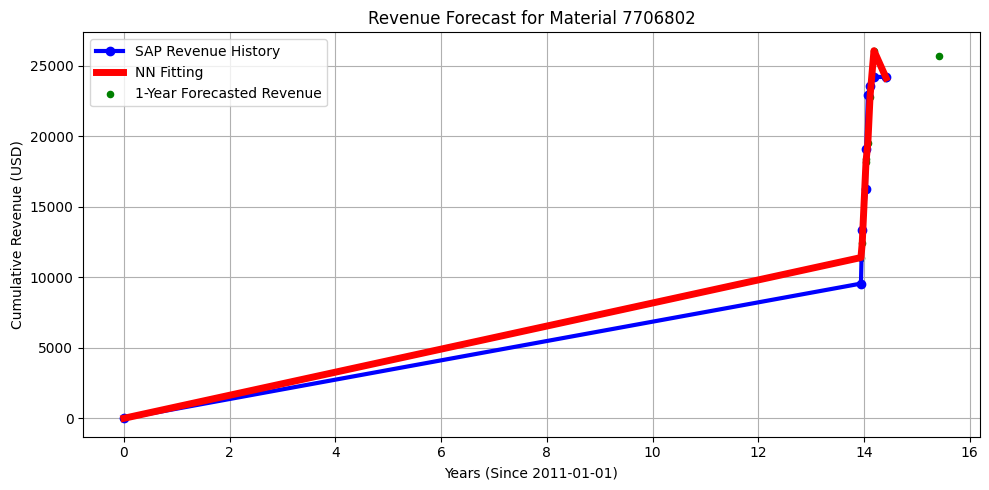

Material Quick Lookup: 7706885



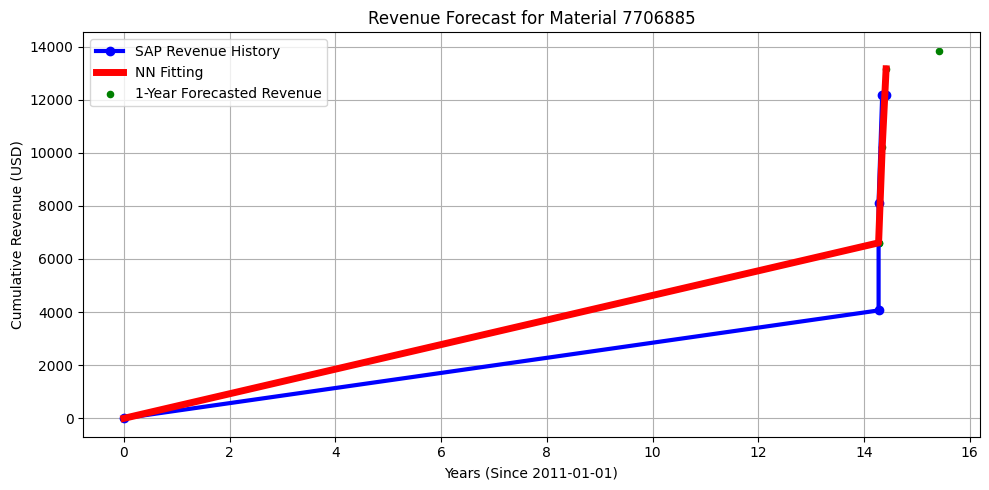

Material Quick Lookup: 2594970



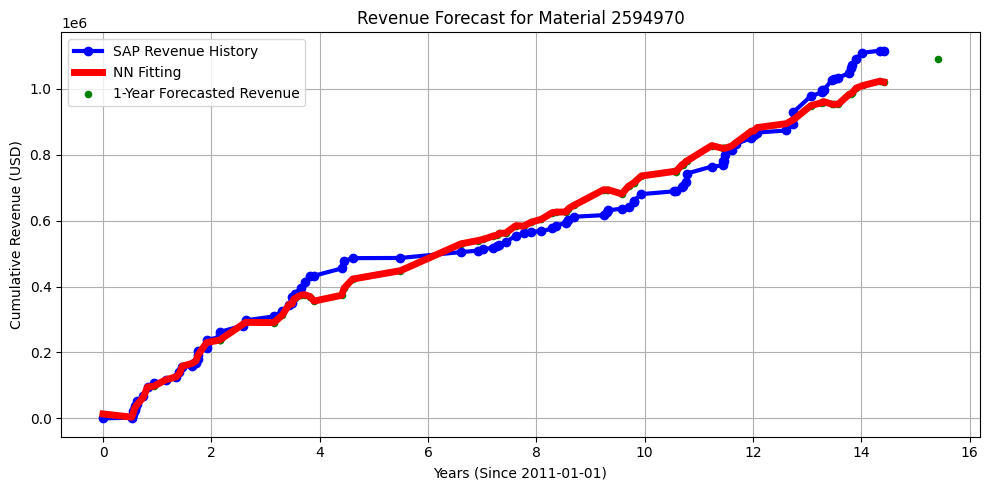

Material Quick Lookup: 7700917



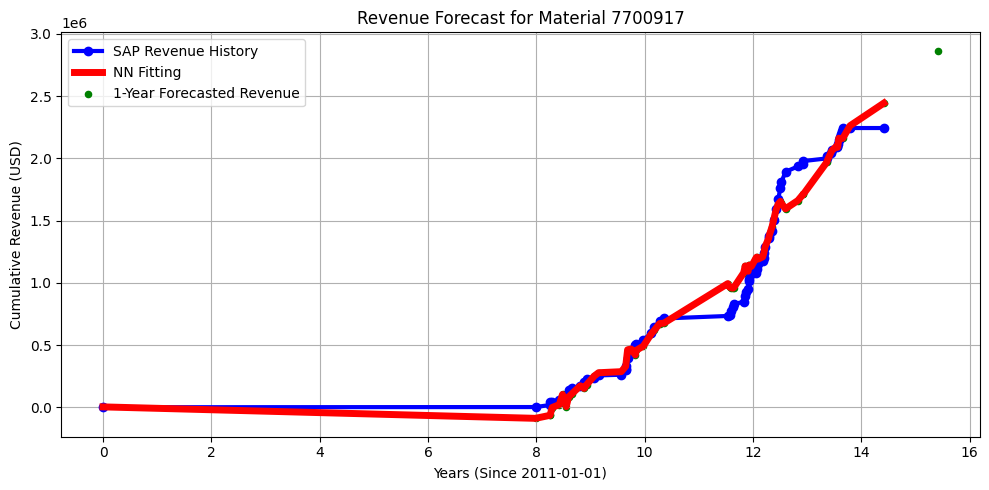

GROUP #1
Best Material | Total Current Revenue (Since 2011) | Total Future Revenue (Since 2011) | Absorbed Cluster Size
7703247.0 | 7064991.98 | 7642974.18 | 101.0


GROUP #2
Best Material | Total Current Revenue (Since 2011) | Total Future Revenue (Since 2011) | Absorbed Cluster Size
2594970.0 | 1115672.32 | 1090017.17 | 1.0


GROUP #3
Best Material | Total Current Revenue (Since 2011) | Total Future Revenue (Since 2011) | Absorbed Cluster Size
7700917.0 | 2243378.46 | 2864577.56 | 1.0




In [54]:
if __name__ == "__main__":
  X = predict_heirarchy(1, viz=True, disp=True)

In [55]:
# function to call all functions and generate the report
def data_report(years):
  print("Beginning predictions...")
  reps = predict_heirarchy(years, viz=False, disp=True)
  print("Predictions complete")
  return reps

In [56]:
# function to place data into a spreadsheet
def record_report(rep_data, filename, group_name):
    import pandas as pd
    import pandas as pd
    from openpyxl import load_workbook
    from openpyxl.styles import Font, Alignment
    import os

    print(f'Recording representatives for {group_name}...')
    flat_data = flat_data = [df.values.tolist()[0] for df in rep_data]

    # Define column names
    columns = [
      "Best Material",
      "Total Current Revenue (Since 2011)",
      "Total Future Revenue (Since 2011)",
      "Absorbed Cluster Size"
    ]

    new_df = pd.DataFrame(flat_data, columns=columns)

    # File already exists
    if os.path.exists(filename):
        # Step 1: Insert merged group_name row manually with openpyxl
        book = load_workbook(filename)
        sheet = book.active
        start_row = sheet.max_row + 1

        # Insert group label
        sheet.cell(row=start_row, column=1).value = group_name
        sheet.cell(row=start_row, column=1).font = Font(bold=True)
        sheet.cell(row=start_row, column=1).alignment = Alignment(horizontal='center')
        sheet.merge_cells(start_row=start_row, start_column=1, end_row=start_row, end_column=4)
        book.save(filename)

        # Step 2: Append data using pandas without passing book
        with pd.ExcelWriter(filename, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            new_df.to_excel(writer, index=False, header=True, startrow=start_row + 1)

    else:
        # File doesn't exist — create it with a header row
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            new_df.to_excel(writer, index=False, header=True, startrow=1)

        # Insert group_name row above using openpyxl
        book = load_workbook(filename)
        sheet = book.active
        sheet.insert_rows(1)
        sheet.cell(row=1, column=1).value = group_name
        sheet.cell(row=1, column=1).font = Font(bold=True)
        sheet.cell(row=1, column=1).alignment = Alignment(horizontal='center')
        sheet.merge_cells(start_row=1, start_column=1, end_row=1, end_column=4)
        book.save(filename)
    print("Complete")

In [57]:
if __name__ == "__main__":
  year = 2026
  harch = '16=05=ZZZ_'
  nname = 'Service Parts'
  entry_name = f'Heirarchy: {harch} ({nname})'
  filename = '/content/drive/My Drive/Colab/RevenueReport_CustomMobile.xlsx'
  data = data_report(year-2025)
  record_report(data, filename, entry_name)

Beginning predictions...


Saving 16_15_30_ACE_EMPTY.xlsx to 16_15_30_ACE_EMPTY.xlsx
Error: not all columns located
Error: not all columns located
Error: not all columns located
Error: Not all required columns are present in the input DataFrame.
Error: not all columns located
Error: not all columns located
Predictions complete
Recording representatives for Heirarchy: 16=05=ZZZ_ (Service Parts)...
Complete
